## Test model using simulated data

### This handbook uses parameters from Autism Data to:

#### Simulate data. 

#### Estimate parameters ($pi, \bar{\gamma}$) using MCMC from the rstan package, and the method of moments.

## Load data and parameters from Autism data

In [55]:
data <- read.table("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header = TRUE, sep = ",")
ntrio <- 2231  # number of trios
ncase <- 1601  # number of cases
nctrl <- 5397  # number of controls
ntrans <- 1333 # number of subjects with transmission data

N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)
#data <- read.table("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header = TRUE, sep = ",")
counts <- as.array(cbind(data$dn.LoF, data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF,
                         data$dn.mis3, data$case.mis3+data$trans.mis3,
                         data$ctrl.mis3+data$ntrans.mis3))
mu.frac <- c(0.074, 0.32)
gamma.mean.dn <- c(20, 4.7)
beta.dn <- c(1,1)
gamma.mean.CC <- c(2.3, 1.00)
beta.CC <- c(4.0, 1000)
rho1 <- c(0.1, 0.5)
nu1 <- c(200, 100)
rho0 <- c(0.1, 0.5)
nu0 <- c(200, 100)
hyperpar <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0))
l <- 100
pi0 <- 0.94 # the fraction of non-risk genes

y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]
y.case.mis3 <- counts[, 5]
y.control.mis3 <- counts[, 6]
head(data, 2)

Gene  mut.rate dn.LoF case.LoF ctrl.LoF trans.LoF ntrans.LoF dn.mis3
1 A1BG 2.355e-05      0        0        1         0          0       0
2 A1CF 2.174e-05      0        1        2         1          1       0
  case.mis3 ctrl.mis3 trans.mis3 ntrans.mis3
1         0         4          7           3
2         0         7          3           7

## Use simulation functions from the TADA package

In [56]:
# Generate simulation data of a set of genes (multiple mutational categories): de novo mutations only
# N: sample size (number of trios)
# mu: mutation rate of each gene (a vector)
# mu.frac: for each type of mutation, its fraction of the gene's mutation rate
# pi: the fraction of risk genes 
# gamma.mean, beta: Relative risk of de novo mutation: gamma|M1 ~ Gamma(gamma.mean*beta, beta). Vectors (one per category) 
# Output: sample matrix (m by K), where m is the number of genes and K the number of variant categories. sample.info: more information of the samples, including the indicator (risk gene or not) and the RR. 

simulator.denovo <- function(N, mu, mu.frac, pi, gamma.mean, beta) {
  m <- length(mu) # number of genes
  K <- length(mu.frac) # number of mutational categories
  
  z <- rbinom(m, 1, pi)
  gamma <- array(1, dim=c(m,K))
  x <- array(0, dim=c(m,K))
  k <- sum(z==1)
  for (j in 1:K) {
    gamma[z==1, j] <- rgamma(k, gamma.mean[j]*beta[j], beta[j])
    x[,j] <- rpois(m, 2 * mu * mu.frac[j] * gamma[,j] * N)
  }
  
  sample.info <- cbind(mu, z, gamma, x)
  
  return (list(sample=x, sample.info=sample.info))
}

# Generate simulation data of a set of genes (multiple mutational categories)
# N: sample size (number of trios)
# mu: mutation rate of each gene (a vector)
# mu.frac: for each type of mutation, its fraction of the gene's mutation rate
# pi: the fraction of risk genes 
# gamma.mean.dn, beta.dn: Relative risk of de novo mutation: gamma|M1 ~ Gamma(gamma.mean.dn*beta.dn, beta.dn). Vectors.
# gamma.mean.CC, beta.CC: Relative risk of inherited mutation (case/control): gamma.CC|M1 ~ Gamma(gamma.mean.CC*beta.CC, beta.CC). Vectors
# Frequency parameter of risk genes: q|M1 ~ Gamma(rho1, nu1)
# Frequency parameter of non-risk genes: q|M0 ~ Gamma(rho0, nu0)
# tradeoff option: if TRUE, implement q-gamma tradeoff (i.e. higher gamma means lower q). Suppose, gamma_i is the RR, then q_i is proportional to mu_i / gamma_i, where the constant is determined from the mean of q, mu and gamma. 
# Output: sample matrix (m by 3K), where m is the number of genes and K the number of variant categories.  sample.info: more information of the samples, including the indicator (risk gene or not) and the RR.
simulator <- function(N, mu, mu.frac, pi, gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0, tradeoff=FALSE) {
  m <- length(mu) # number of genes
  K <- length(mu.frac) # number of mutational categories
  
  # the tradeoff parameter (delta:=mu.mean/q.mean)
  delta <- mean(mu) * mu.frac / (rho0 / nu0)
  
  z <- rbinom(m, 1, pi)
  gamma.dn <- array(1, dim=c(m,K))
  gamma.CC <- array(1, dim=c(m,K))
  q <- array(0, dim=c(m,K))
  x <- array(0, dim=c(m,3*K))
  k <- sum(z==1)
  for (j in 1:K) {
    # sample de novo 
    gamma.dn[z==1, j] <- rgamma(k, gamma.mean.dn[j]*beta.dn[j], beta.dn[j])
    col <- 3*(j-1)+1
    x[,col] <- rpois(m, 2 * mu * mu.frac[j] * gamma.dn[,j] * N$dn)
    
    # sample case-control
    gamma.CC[z==1, j] <- rgamma(k, gamma.mean.CC[j]*beta.CC[j], beta.CC[j])
    q[z==0, j] <- rgamma(m-k, rho0[j], nu0[j])
    if (tradeoff==FALSE) {
      q[z==1, j] <- rgamma(k, rho1[j], nu1[j])
    } else {
      q[z==1, j] <- mu[z==1] * mu.frac[j] / (delta[j] * gamma.CC[z==1, j])
    }
    x[,col+1] <- rpois(m, q[,j] * gamma.CC[,j] *N$ca)
    x[,col+2] <- rpois(m, q[,j] * N$cn)
    
  }
  
  sample.info <- cbind(mu, z, gamma.dn, gamma.CC, q, x)
  
  return (list(sample=x, sample.info=sample.info))
}



## Simulate for single category

### MCMC code using rstan

In [3]:
denovoBinomSingle <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ndn;

int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];
}
parameters {
real<lower=0.0,upper=0.4> pi0;
real<lower=1> hyperGammaMeanLoFdn;
//real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;


}

model {

real ps[K];
//pi0 ~ normal(0.1, 0.03);
//denovo lof
hyperGammaMeanLoFdn ~ uniform(1, 70); //normal(15, 100);
//hyperBetaLoFdn ~ normal(1, 0.01);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn, 1);


for (ii in 1:NN){
ps[1] <- log1m(pi0) 
//+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]);
+ poisson_log(yLoFdn[ii], Ndn*2*mutLoF[ii]);

ps[2] <- log(pi0)
//+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]*gammaLoFdn);
+ poisson_log(yLoFdn[ii], Ndn*2*mutLoF[ii]*gammaLoFdn);

increment_log_prob(log_sum_exp(ps));
}

}
"


### Simulate only single de novo category

In [11]:
sDenovo <- simulator.denovo(N = N$dn, mu = data$mut.rate, mu.frac = mu.frac[1], pi = 0.03, gamma.mean = 23, beta = 1)

class(sDenovo)
str(sDenovo)

sCountDenovo <- as.numeric(sDenovo[[1]])
table(sCountDenovo)


[1] "list"

List of 2
 $ sample     : num [1:18735, 1] 0 0 0 0 0 0 2 0 0 0 ...
 $ sample.info: num [1:18735, 1:4] 2.35e-05 2.17e-05 6.09e-06 5.64e-05 5.70e-05 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:4] "mu" "z" "" ""


sCountDenovo
    0     1     2     3     4 
18492   230    11     1     1 

### Estimate $\pi$ using the method of moments

In [12]:
source("newTADA2016/TADA/TADA.v1.1.R")


mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  sCountDenovo

C=sum(yLoF)
listGamma <- NULL
listM <- NULL
d0 = 1

listK <- c(10, 50, 75, 100, 200, 500, 0.03*length(yLoF), 700, 1000, 1500, 2000, 2500, 3000)
for (k in 1:length(listK)){
results=denovo.MOM(k= listK[k], N=N$dn, mu= mutLoF, C=C, beta=1, d= d0)
gamma.mean.dn=results$gamma.mean
M.expected=results$M
listGamma[k] <- gamma.mean.dn
listM[k] <- M.expected
}

M.observed <- length(yLoF[yLoF>= d0])


In [13]:
outResult <- cbind(round(listK, 2), listGamma, listM, round(listK/length(yLoF), 3), abs(listM - M.observed))
colnames(outResult) <- c("nGene", "GammaMean", "M.expected", "Risk_gene_proportion", "Distance_M.ob_AND_es")
outResult[order(outResult[, 5]), ]


nGene   GammaMean M.expected Risk_gene_proportion Distance_M.ob_AND_es
 [1,]   75.00  179.704844  27.935283                0.004             215.0647
 [2,]  100.00  135.028633  27.915907                0.005             215.0841
 [3,]   50.00  269.057266  26.250174                0.003             216.7498
 [4,]  200.00   68.014317  24.347465                0.011             218.6525
 [5,]  500.00   27.805727  16.428617                0.027             226.5714
 [6,]  562.05   24.846390  15.452325                0.030             227.5477
 [7,]  700.00   20.146948  13.733555                0.037             229.2664
 [8,] 1000.00   14.402863  11.327148                0.053             231.6729
 [9,]   10.00 1341.286331  10.575770                0.001             232.4242
[10,] 1500.00    9.935242   9.157710                0.080             233.8423
[11,] 2000.00    7.701432   7.943338                0.107             235.0567
[12,] 2500.00    6.361145   7.213359                0.133             235.7866
[13,] 3000.00    5.467621   6.680368                0.160             236.3196

#### Change d

In [14]:
source("newTADA2016/TADA/TADA.v1.1.R")


mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  sCountDenovo

C=sum(yLoF)
listGamma <- NULL
listM <- NULL
d0 = 2

listK <- c(10, 50, 75, 100, 200, 500, 0.03*length(yLoF), 700, 1000, 1500, 2000, 2500, 3000)
for (k in 1:length(listK)){
results=denovo.MOM(k= listK[k], N=N$dn, mu= mutLoF, C=C, beta=1, d= d0)
gamma.mean.dn=results$gamma.mean
M.expected=results$M
listGamma[k] <- gamma.mean.dn
listM[k] <- M.expected
}

M.observed <- length(yLoF[yLoF>= d0])


In [15]:
outResult <- cbind(round(listK, 2), listGamma, listM, round(listK/length(yLoF), 3), abs(listM - M.observed))
colnames(outResult) <- c("nGene", "GammaMean", "M.expected", "Risk_gene_proportion", "Distance_M.ob_AND_es")
outResult[order(outResult[, 5]), ]


nGene   GammaMean M.expected Risk_gene_proportion Distance_M.ob_AND_es
 [1,]  100.00  135.028633 12.4142857                0.005            0.5857143
 [2,]   75.00  179.704844 14.2011775                0.004            1.2011775
 [3,]   50.00  269.057266 15.7837522                0.003            2.7837522
 [4,]   10.00 1341.286331  8.8475269                0.001            4.1524731
 [5,]  200.00   68.014317  7.5147952                0.011            5.4852048
 [6,]  500.00   27.805727  2.9111993                0.027           10.0888007
 [7,]  562.05   24.846390  2.5475503                0.030           10.4524497
 [8,]  700.00   20.146948  1.9628202                0.037           11.0371798
 [9,] 1000.00   14.402863  1.2898108                0.053           11.7101892
[10,] 1500.00    9.935242  0.8240494                0.080           12.1759506
[11,] 2000.00    7.701432  0.6175560                0.107           12.3824440
[12,] 2500.00    6.361145  0.5071082                0.133           12.4928918
[13,] 3000.00    5.467621  0.4412637                0.160           12.5587363

### Use function from old version of TADAT

In [16]:
source("TADA/TADA.R")

mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  sCountDenovo
#yLoF <- data$dn.LoF
C=sum(yLoF)
listGamma <- NULL
listM <- NULL
d0 = 2

listK <- seq(10, 6000, by = 200) #c(10, 50, 75, 100, 200, 500, 0.03*length(yLoF), 700, 1000, 1500, 2000, 
#           2500, 3000, 3500, 4000, 5000, 0.2*length(yLoF))
for (k in 1:length(listK)){
  results=denovo.MOM(k= listK[k], N=N$dn, mu= mutLoF, C=C, beta=1)
  gamma.mean.dn=results$gamma.mean
  M.expected=results$M
  listGamma[k] <- gamma.mean.dn
  listM[k] <- M.expected
}

M.observed <- length(yLoF[yLoF>= d0])

outResult <- cbind(round(listK, 2), listGamma, listM, round(listK/length(yLoF), 3), abs(listM - M.observed))
colnames(outResult) <- c("nGene", "GammaMean", "M.expected", "Risk_gene_proportion", "Distance_M.ob_AND_es")
outResult[order(outResult[, 5]), ]



nGene   GammaMean M.expected Risk_gene_proportion Distance_M.ob_AND_es
 [1,]   810   17.546745  12.628319                0.043            0.3716809
 [2,]   610   22.971907  14.708740                0.033            1.7087401
 [3,]  1010   14.270162  11.276466                0.054            1.7235339
 [4,]    10 1341.286331  10.575840                0.001            2.4241598
 [5,]  1210   12.076747  10.251054                0.065            2.7489458
 [6,]  1410   10.505577   9.420676                0.075            3.5793235
 [7,]  1610    9.324760   8.858650                0.086            4.1413502
 [8,]  1810    8.404897   8.280837                0.097            4.7191627
 [9,]  2010    7.668091   7.952411                0.107            5.0475892
[10,]   410   33.689911  18.100965                0.022            5.1009646
[11,]  2210    7.064644   7.564441                0.118            5.4355589
[12,]  2410    6.561354   7.398752                0.129            5.6012481
[13,]  2610    6.135197   7.054498                0.139            5.9455016
[14,]  2810    5.769702   6.940513                0.150            6.0594866
[15,]  3010    5.452779   6.669086                0.161            6.3309142
[16,]  3210    5.175347   6.542811                0.171            6.4571887
[17,]  3410    4.930458   6.335746                0.182            6.6642540
[18,]  3810    4.517812   6.176784                0.203            6.8232164
[19,]  3610    4.712705   6.143655                0.193            6.8563445
[20,]  4210    4.183578   6.048553                0.225            6.9514473
[21,]  4010    4.342360   6.006706                0.214            6.9932939
[22,]  4410    4.039198   5.932598                0.235            7.0674019
[23,]  4610    3.907346   5.857363                0.246            7.1426371
[24,]  4810    3.786458   5.791860                0.257            7.2081402
[25,]  5010    3.675222   5.791514                0.267            7.2084857
[26,]  5610    3.389102   5.698987                0.299            7.3010134
[27,]  5810    3.306861   5.645290                0.310            7.3547101
[28,]  5210    3.572527   5.615590                0.278            7.3844104
[29,]  5410    3.477424   5.611001                0.289            7.3889986
[30,]   210   64.823159  24.003245                0.011           11.0032455

#### Use approximation

In [17]:
mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  sCountDenovo
mixdataSingle <- list(K = 2, 
                      yLoFdn = yLoF, mutLoF = mutLoF,
                      Ndn = N$dn, NN = length(yLoF))                 
library("rstan")
nSeed <- 233
mLoF <- stan_model(model_code = denovoBinomSingle)

fLoF <- vb(mLoF, seed = nSeed, data = mixdataSingle)

fLoF


Loading required package: ggplot2
rstan (Version 2.9.0, packaged: 2016-01-05 16:17:47 UTC, GitRev: 05c3d0058b6a)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())



This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.008627 seconds
1000 iterations under these settings should take 8.627 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -1e+03             1.000            1.000
   200    -1302.0             0.502            1.000
   300    -1301.4             0.335            0.005   MEDIAN ELBO CONVERGED

Drawing 1000 samples from the approximate posterior... COMPLETED.


We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: e7bbaacf0e818149de4ff9f10e60cad7.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                     mean   sd  2.5%   25%   50%   75% 97.5%
pi0                  0.05 0.01  0.03  0.04  0.05  0.05  0.07
hyperGammaMeanLoFdn 21.37 3.88 15.20 18.59 21.07 23.54 29.87
gammaLoFdn          18.88 2.36 14.52 17.24 18.77 20.39 23.83
lp__                 0.00 0.00  0.00  0.00  0.00  0.00  0.00

Approximate samples were drawn using VB(meanfield) at Sun Mar  6 17:22:18 2016.

#### Use MCMC

In [18]:
nIteration = 10000
nThin = floor(nIteration/1000)

testFitSingle <- stan(model_code = denovoBinomSingle,
                      data = mixdataSingle, iter = nIteration, chains = 1, thin = nThin, 
                      #control = list(adapt_delta = 0.9),
                      pars = c('pi0','hyperGammaMeanLoFdn'))


SAMPLING FOR MODEL 'e7bbaacf0e818149de4ff9f10e60cad7' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1, Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1, Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1, Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1, Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1, Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1, Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1, Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1, Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1, Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1, Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1, Iteration: 10000 / 10000 [100%]  (Sampling)# 
#  Elapsed Time: 304.107 seconds (Warm-up)
#                378.249 seconds (Sampling)
#                682.356 seconds (Total)
# 


Inference for Stan model: e7bbaacf0e818149de4ff9f10e60cad7.
1 chains, each with iter=10000; warmup=5000; thin=10; 
post-warmup draws per chain=500, total post-warmup draws=500.

                        mean se_mean   sd     2.5%      25%      50%      75%
pi0                     0.04    0.00 0.02     0.02     0.03     0.04     0.05
hyperGammaMeanLoFdn    21.08    0.36 8.13     8.73    15.35    20.00    25.36
lp__                -1295.76    0.07 1.40 -1299.48 -1296.45 -1295.41 -1294.65
                       97.5% n_eff Rhat
pi0                     0.08   500    1
hyperGammaMeanLoFdn    39.67   500    1
lp__                -1294.17   454    1

Samples were drawn using NUTS(diag_e) at Sun Mar  6 17:33:40 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

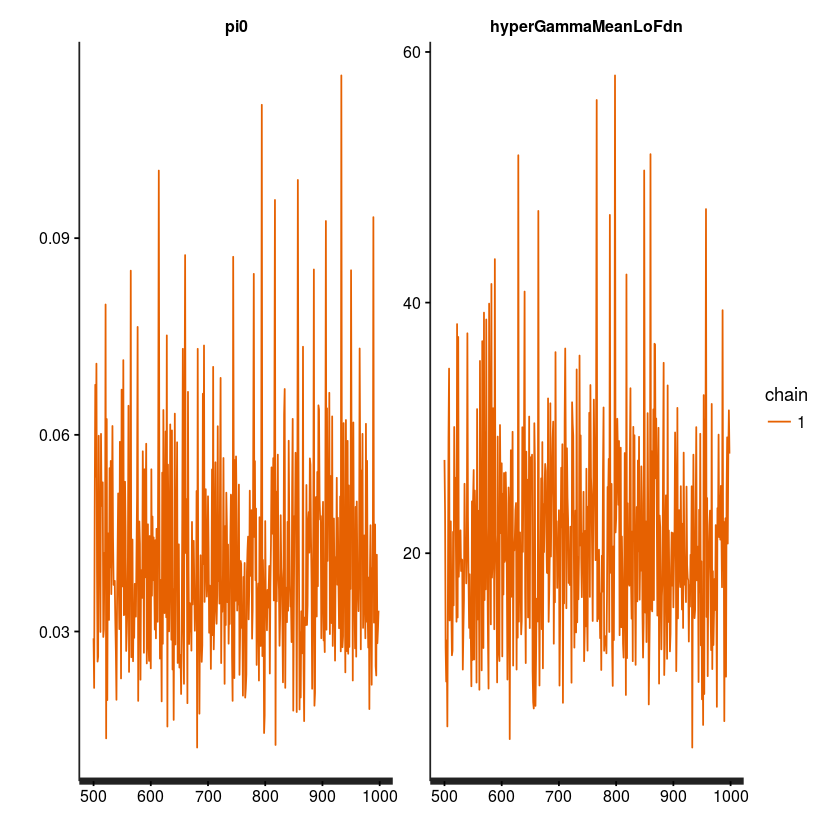

In [19]:
stan_trace(testFitSingle)
testFitSingle

V1 V2   V3   V4       V5          V6        V7          V8
1 100 10 0.01 9310 2.258492 0.009184432 0.4969309 0.009184432
2 100 10 0.03 9760 1.916827 0.007528214 0.5209501 0.007528214
3 100 10 0.05 3460 1.986008 0.004410967 0.1846811 0.004410967
4 100 10 0.07 9860 2.469055 0.011294536 0.5262877 0.011294536
5 100 10 0.09 9310 2.258492 0.009346863 0.4969309 0.009346863
6 100 10 0.11 8910 2.314989 0.009308458 0.4755805 0.009308458

[1] 2423 1509 2270 2874 3325  302  453  604  755  906 1057 1208 1359 1660 1811

Warning message:
In heatmap.2(momTable, Rowv = FALSE, Colv = FALSE, col = greenred(6), : Discrepancy: Rowv is FALSE, while dendrogram is `none'. Omitting row dendogram.

V1 V2   V3       V4         V5
1 1050 11 0.01 15.87133 0.06100676
2 1050 11 0.03 10.92205 0.09988880
3 1050 11 0.05 22.68286 0.04548404
4 1050 11 0.07 11.53354 0.13137062
5 1050 11 0.09 13.27117 0.13032637
6 1050 11 0.11 13.12481 0.14954210

Warning message:
In heatmap.2(mcmcTable, Rowv = FALSE, Colv = FALSE, col = greenred(6), : Discrepancy: Rowv is FALSE, while dendrogram is `none'. Omitting row dendogram.

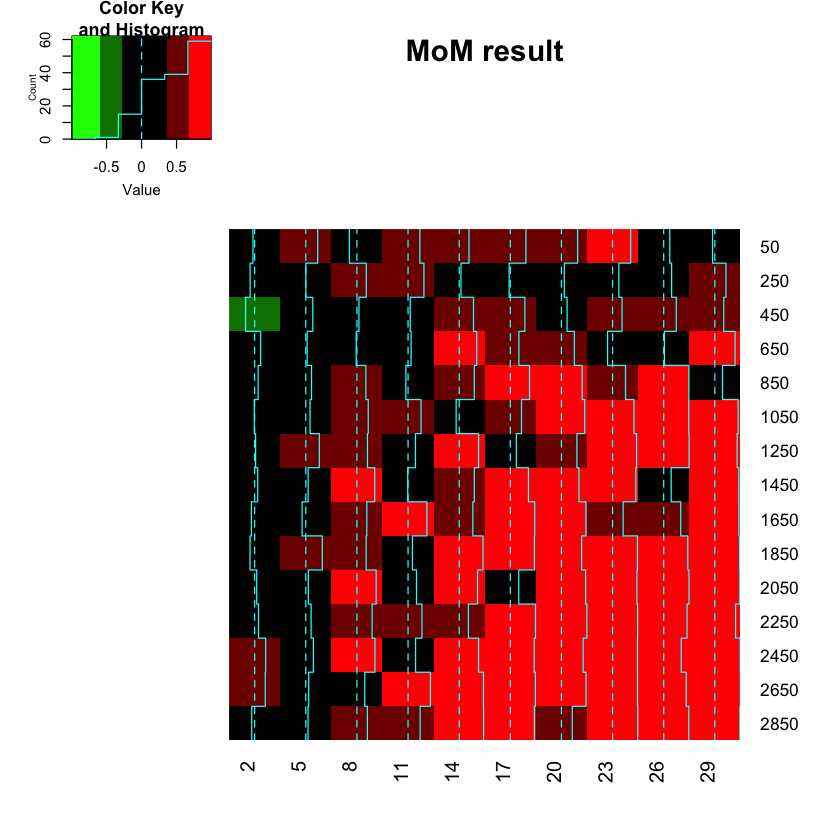

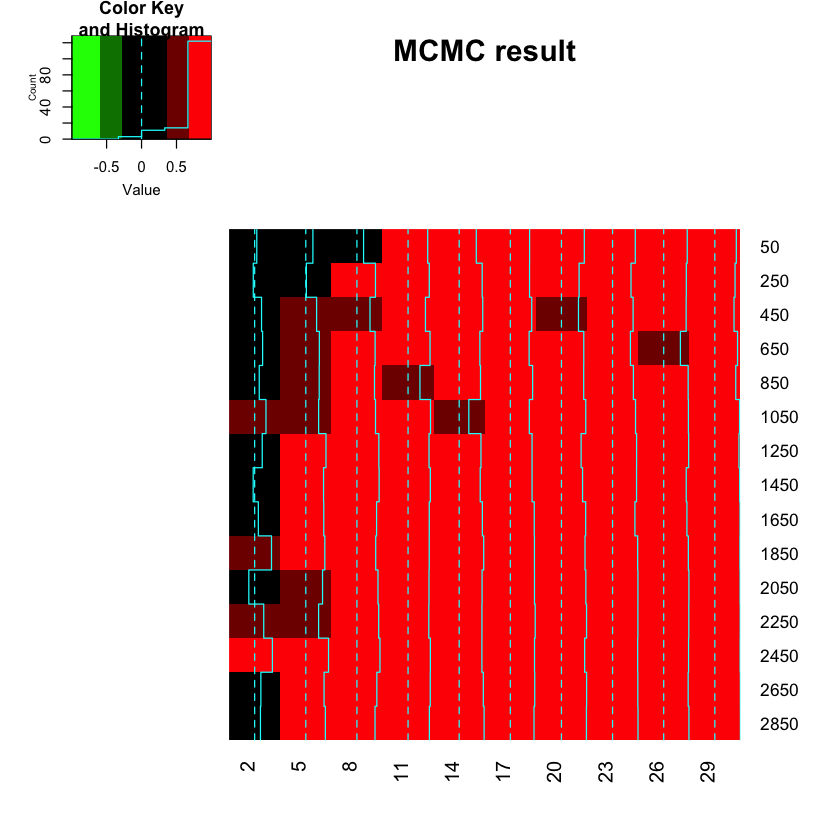

In [3]:
library("gplots")
xMOM <- read.table("../data/xem.MOM.txt", header = FALSE)

head(xMOM)
x1 <- table(xMOM[, 1])
x1 <- as.numeric(names(x1[x1 == 150]))
pmatch(x1, xMOM[, 1])
xOut <- NULL
for (ii in 1:length(x1)){
  xOut <- rbind(xOut, xMOM[xMOM[, 1] == x1[ii], ])
}

xGamma <- as.numeric(names(table(xOut[, 2])))
xTrio <- as.numeric(names(table(xOut[, 1])))

momTable <- matrix(0, nrow = length(xTrio), ncol = length(xGamma))
for (i in 1:length(xTrio)){
  for (j in 1:length(xGamma)){
    xTemp <- xOut[xOut[, 1] == xTrio[i], ]
    xTemp <- xTemp[xTemp[, 2] == xGamma[j], ]
    momTable[i, j] <- cor(xTemp[, 3], xTemp[, 7])
    
  }
}
rownames(momTable) <- xTrio
colnames(momTable) <- xGamma
#heatmap(momTable, Colv = NA, Rowv = NA, col = greenred(100), scale = "none", 
 #       main = 'MOM result', , xlab = 'Number of trios', ylab = 'HyperGammaMean')
heatmap.2(momTable, Rowv = FALSE, Colv = FALSE, col = greenred(6),
          main ='MoM result')

#####MCMC table
xMCMC <- read.table("../data/xem.MCMC.txt", header = FALSE)

xOut <- xMCMC
xGamma <- as.numeric(names(table(xOut[, 2])))
xTrio <- as.numeric(names(table(xOut[, 1])))
head(xMCMC)
mcmcTable <- matrix(0, nrow = length(xTrio), ncol = length(xGamma))
for (i in 1:length(xTrio)){
  for (j in 1:length(xGamma)){
    xTemp <- xOut[xOut[, 1] == xTrio[i], ]
    xTemp <- xTemp[xTemp[, 2] == xGamma[j], ]
    mcmcTable[i, j] <- cor(xTemp[, 3], xTemp[, 5])
    
  }
}
rownames(mcmcTable) <- xTrio
colnames(mcmcTable) <- xGamma
#heatmap(mcmcTable, Colv = NA, Rowv = NA, col = greenred(100), scale = "none", 
 #       main ='MCMC result', xlab = 'Number of trios', ylab = 'HyperGammaMean')
heatmap.2(mcmcTable, Rowv = FALSE, Colv = FALSE, col = greenred(6),
          main ='MCMC result')

V1 V2   V3       V4         V5
1 1050 11 0.01 15.87133 0.06100676
2 1050 11 0.03 10.92205 0.09988880
3 1050 11 0.05 22.68286 0.04548404
4 1050 11 0.07 11.53354 0.13137062
5 1050 11 0.09 13.27117 0.13032637
6 1050 11 0.11 13.12481 0.14954210

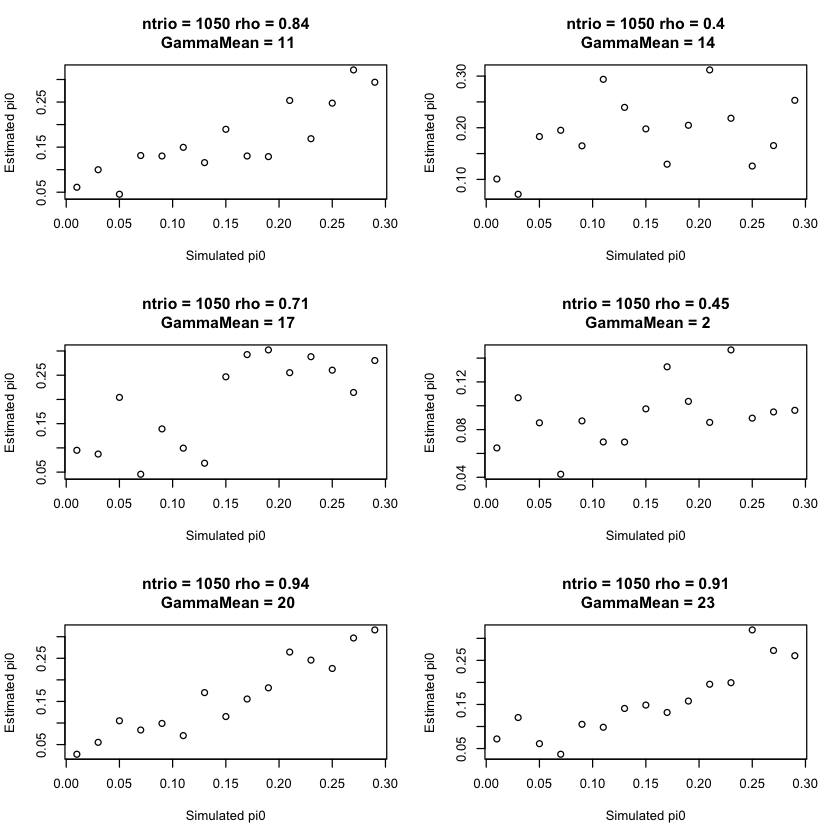

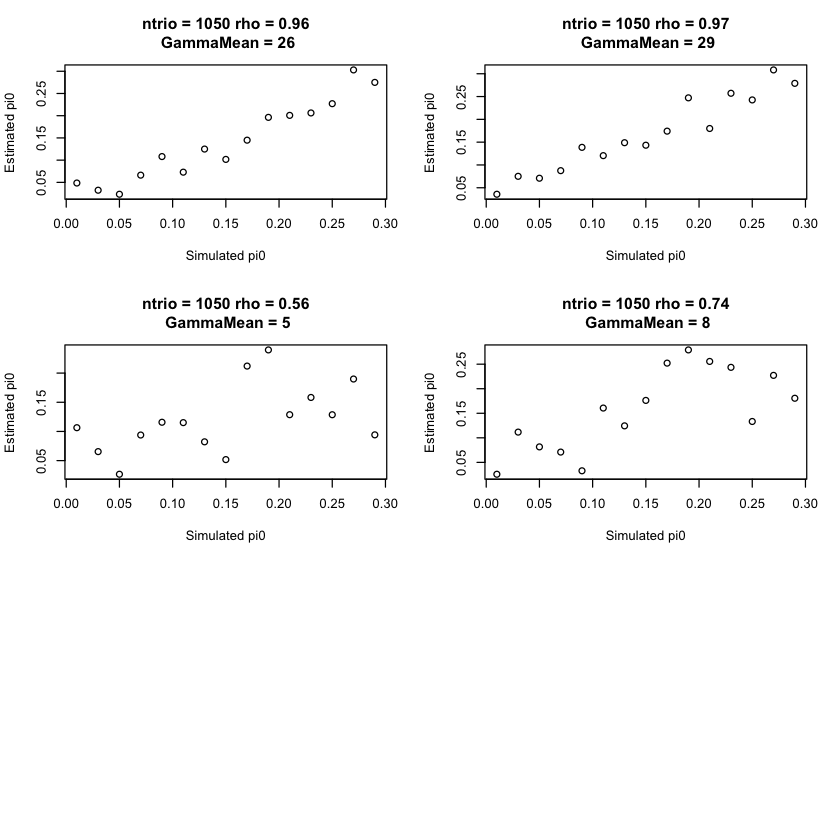

In [43]:
momResult <- read.table("../data/xem.MCMC.txt")
head(momResult)

iColumn <- 5

nTrioList <- unique(momResult[, 1])
nTrioList1 <- nTrioList
nGammaList <- unique(momResult[, 2])
nGammaList1 <- nGammaList
pOut <- NULL
kk <- 1
ii = 1
par(mfrow = c(3, 2))
for (jj in nGammaList){
    tFile <- momResult[(momResult[, 1] == nTrioList[ii]) &
                    (momResult[, 2 ] == jj), ]
    tCor <- round(cor(tFile[, 3], tFile[, iColumn], method = 'spearman'), 2)
    plot(tFile[, 3], tFile[, iColumn], xlab = 'Simulated pi0', ylab = 'Estimated pi0',
        main = paste('ntrio = ', nTrioList[ii], ' rho = ', tCor, '\n GammaMean = ', jj, sep = '') )
    pOut[[kk] ] <- c(nTrioList[ii], jj, tCor)
    kk <- kk + 1
}

In [44]:
pOut <- do.call(rbind, pOut)
pOut <- pOut[order(as.numeric(pOut[, 3])), ]
pOut

[,1] [,2] [,3]
 [1,] 1050   14 0.40
 [2,] 1050    2 0.45
 [3,] 1050    5 0.56
 [4,] 1050   17 0.71
 [5,] 1050    8 0.74
 [6,] 1050   11 0.84
 [7,] 1050   23 0.91
 [8,] 1050   20 0.94
 [9,] 1050   26 0.96
[10,] 1050   29 0.97

V1 V2   V3   V4       V5          V6        V7          V8
1 100 10 0.01 9310 2.258492 0.009184432 0.4969309 0.009184432
2 100 10 0.03 9760 1.916827 0.007528214 0.5209501 0.007528214
3 100 10 0.05 3460 1.986008 0.004410967 0.1846811 0.004410967
4 100 10 0.07 9860 2.469055 0.011294536 0.5262877 0.011294536
5 100 10 0.09 9310 2.258492 0.009346863 0.4969309 0.009346863
6 100 10 0.11 8910 2.314989 0.009308458 0.4755805 0.009308458

[1] 1050 1250 1450 1650 1850 2050 2250 2450  250 2650 2850  450   50  650  850

[1] 1

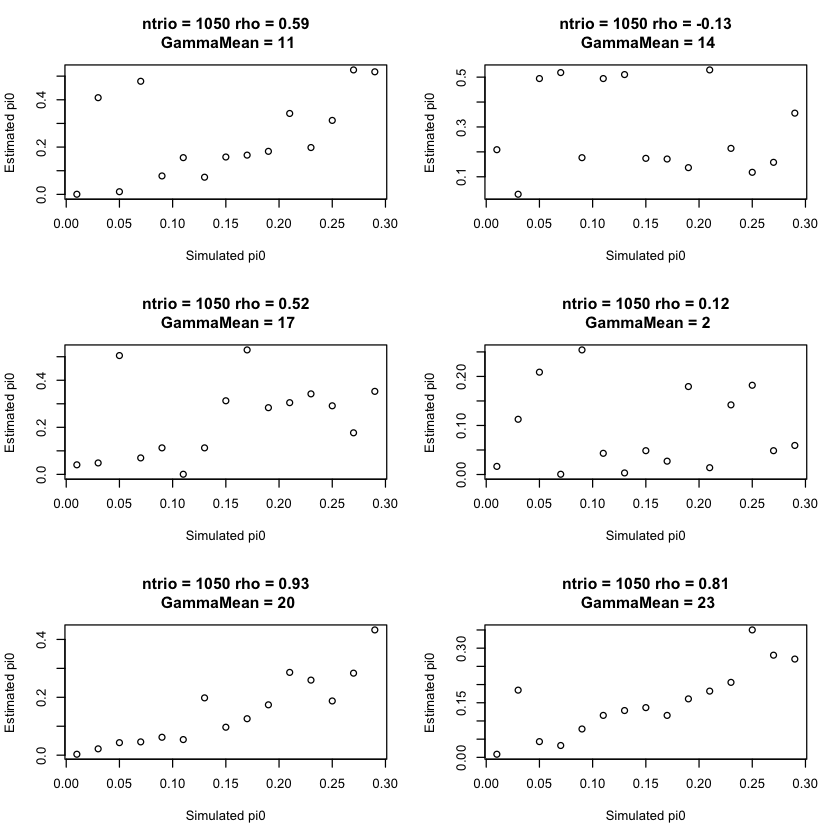

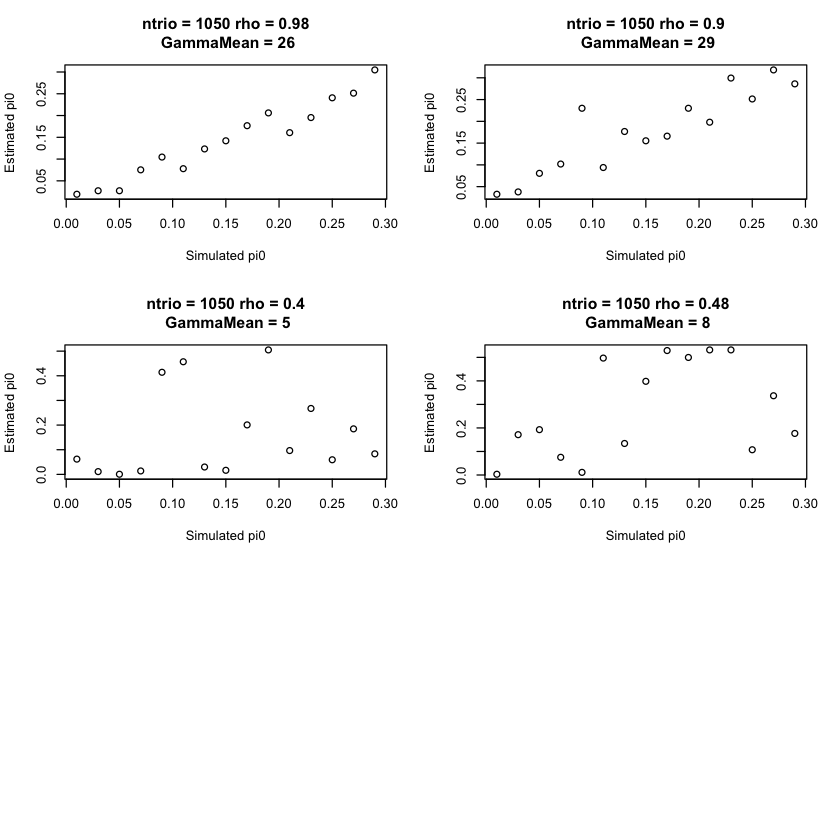

In [45]:
momResult <- read.table("../data/xem.MOM.txt")
head(momResult)

nTrioList <- nTrioList1
nTrioList
nGammaList <- nGammaList1
pOut <- NULL
kk <- 1
ii <- 1
ii
par(mfrow = c(3, 2))
for (jj in nGammaList1){
    tFile <- momResult[(momResult[, 1] == nTrioList[ii]) &
                    (momResult[, 2 ] == jj), ]
    tCor <- round(cor(tFile[, 3], tFile[, 7], method = 'spearman'), 2)
    plot(tFile[, 3], tFile[, 7], xlab = 'Simulated pi0', ylab = 'Estimated pi0',
        main = paste('ntrio = ', nTrioList[ii], ' rho = ', tCor, '\n GammaMean = ', jj, sep = '') )
    pOut[[kk] ] <- c(nTrioList[ii], jj, tCor)
    kk <- kk + 1
}

### Use MCMC on the grid

In [46]:
pOut <- do.call(rbind, pOut)
pOut <- pOut[order(as.numeric(pOut[, 3])), ]
pOut

[,1] [,2]  [,3]
 [1,] 1050   14 -0.13
 [2,] 1050    2  0.12
 [3,] 1050    5  0.40
 [4,] 1050    8  0.48
 [5,] 1050   17  0.52
 [6,] 1050   11  0.59
 [7,] 1050   23  0.81
 [8,] 1050   29  0.90
 [9,] 1050   20  0.93
[10,] 1050   26  0.98

### Test different $\pi$ with the method of moments

Warning message:
In rgamma(S, gamma.mean * beta, rate = beta): NAs producedWarning message:
In rgamma(S, gamma.mean * beta, rate = beta): NAs producedWarning message:
In rgamma(S, gamma.mean * beta, rate = beta): NAs producedWarning message:
In rgamma(S, gamma.mean * beta, rate = beta): NAs producedWarning message:
In rgamma(S, gamma.mean * beta, rate = beta): NAs producedWarning message:
In rgamma(S, gamma.mean * beta, rate = beta): NAs producedWarning message:
In rgamma(S, gamma.mean * beta, rate = beta): NAs producedWarning message:
In rgamma(S, gamma.mean * beta, rate = beta): NAs producedWarning message:
In rgamma(S, gamma.mean * beta, rate = beta): NAs producedWarning message:
In rgamma(S, gamma.mean * beta, rate = beta): NAs producedWarning message:
In rgamma(S, gamma.mean * beta, rate = beta): NAs producedWarning message:
In rgamma(S, gamma.mean * beta, rate = beta): NAs producedWarning message:
In rgamma(S, gamma.mean * beta, rate = beta): NAs producedWarning message:
In rgamm

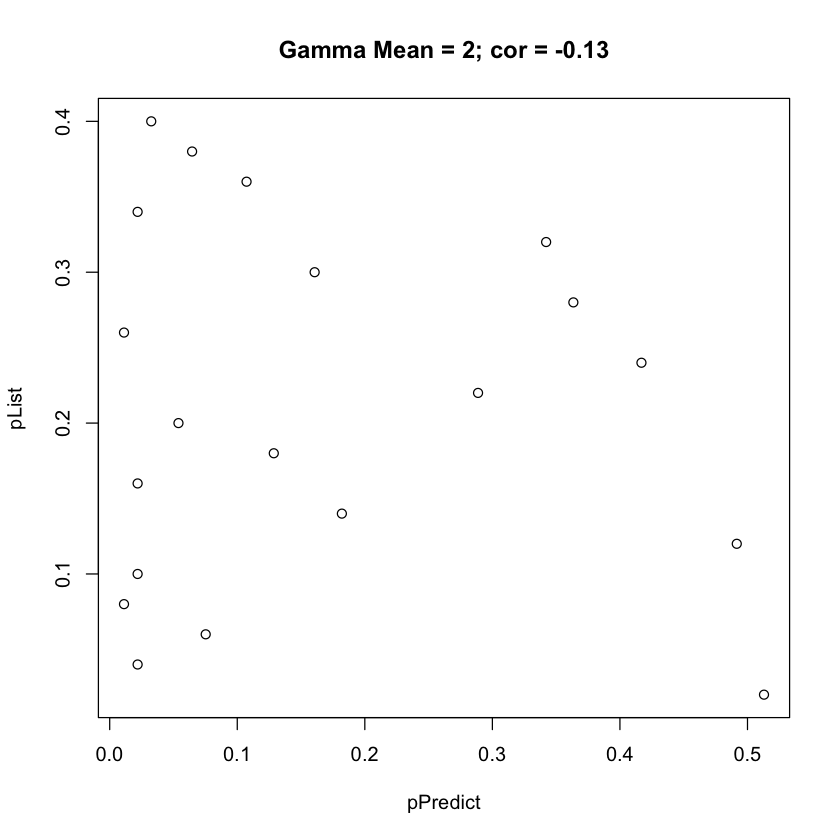

In [ ]:
yLoFList <- NULL
pList <- seq(0.02, 0.4, by = 0.02)
pPredict <- NULL

###Change gamma mean
allLoF <- NULL
for (iGamma in seq(2, 30, by = 2)[1]){

for (i in 1:length(pList)){
sDenovo <- simulator.denovo(N = N$dn, mu = data$mut.rate, mu.frac = mu.frac[1], pi = pList[i], 
                            gamma.mean = iGamma, beta = 1)

sCountDenovo <- as.numeric(sDenovo[[1]])
table(sCountDenovo)
source("TADA/TADA.R")

mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  sCountDenovo
yLoFList[[i]] <- yLoF
C=sum(yLoF)
listGamma <- NULL
listM <- NULL
d0 = 2

listK <- seq(10, 10000, by = 200) 
    
for (k in 1:length(listK)){
  results=denovo.MOM(k= listK[k], N=N$dn, mu= mutLoF, C=C, beta=1)
  gamma.mean.dn=results$gamma.mean
  M.expected=results$M
  listGamma[k] <- gamma.mean.dn
  listM[k] <- M.expected
}

M.observed <- length(yLoF[yLoF>= d0])
outResult <- cbind(listK, listGamma, listM, listK/length(yLoF), abs(listM - M.observed))
t1 <- outResult[order(outResult[, 5]), ]
pPredict[i] <- t1[1,4]
}



a1 <- cbind(pPredict, pList)
plot(a1, main = paste("Gamma Mean = ", iGamma, "; cor = ", round(cor(a1[, 1], a1[, 2]), 2), sep = ""))
cor(a1)
    
    allLoF[[iGamma]] <- yLoFList

}

In [32]:
a1

pPredict pList
 [1,] 0.0053376034  0.02
 [2,] 0.0005337603  0.04
 [3,] 0.0600000000  0.06
 [4,] 0.0746623966  0.08
 [5,] 0.0946623966  0.10
 [6,] 0.1601281025  0.12
 [7,] 0.1067520683  0.14
 [8,] 0.1653376034  0.16
 [9,] 0.2135041366  0.18
[10,] 0.2135041366  0.20
[11,] 0.2253376034  0.22
[12,] 0.2453376034  0.24
[13,] 0.2653376034  0.26
[14,] 0.0053376034  0.28
[15,] 0.3000000000  0.30
[16,] 0.0053376034  0.32
[17,] 0.0053376034  0.34
[18,] 0.3600000000  0.36
[19,] 0.3746623966  0.38
[20,] 0.3946623966  0.40

In [35]:
outP <- NULL
for (ii in 1:length(yLoFList)){
mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  yLoFList[[ii]]
mixdataSingle <- list(K = 2, 
                      yLoFdn = yLoF, mutLoF = mutLoF,
                      Ndn = N$dn, NN = length(yLoF))                 
nIteration = 3000
nThin = floor(nIteration/1000)
nChain <- nCore <- 2
testFitSingle <- stan(model_code = denovoBinomSingle,
                      data = mixdataSingle, iter = nIteration, chains = nChain, thin = nThin, 
                      cores = nCore,
                      #control = list(adapt_delta = 0.9),
                      pars = c('pi0','hyperGammaMeanLoFdn'))

outT <- extract(testFitSingle, pars = 'pi0')

outP[ii] <- mean(outT[[1]])
    
}

Warning message:
: There were 24 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.Warning message:
: Examine the pairs() plot to diagnose sampling problems
Warning message:
: There were 4 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.Warning message:
: Examine the pairs() plot to diagnose sampling problems


In [36]:
outP

[1] 0.04212295 0.03376377 0.05233623 0.06881728 0.10474352 0.12362089
 [7] 0.12998281 0.14445352 0.21095694 0.21337301 0.23574268 0.26279888
[13] 0.25403326 0.32226285 0.29806100 0.33656985 0.34389112 0.34526584
[19] 0.35718257 0.33387946

outP     pPredict pList
 [1,] 0.04212295 0.0053376034  0.02
 [2,] 0.03376377 0.0005337603  0.04
 [3,] 0.05233623 0.0600000000  0.06
 [4,] 0.06881728 0.0746623966  0.08
 [5,] 0.10474352 0.0946623966  0.10
 [6,] 0.12362089 0.1601281025  0.12
 [7,] 0.12998281 0.1067520683  0.14
 [8,] 0.14445352 0.1653376034  0.16
 [9,] 0.21095694 0.2135041366  0.18
[10,] 0.21337301 0.2135041366  0.20
[11,] 0.23574268 0.2253376034  0.22
[12,] 0.26279888 0.2453376034  0.24
[13,] 0.25403326 0.2653376034  0.26
[14,] 0.32226285 0.0053376034  0.28
[15,] 0.29806100 0.3000000000  0.30
[16,] 0.33656985 0.0053376034  0.32
[17,] 0.34389112 0.0053376034  0.34
[18,] 0.34526584 0.3600000000  0.36
[19,] 0.35718257 0.3746623966  0.38
[20,] 0.33387946 0.3946623966  0.40

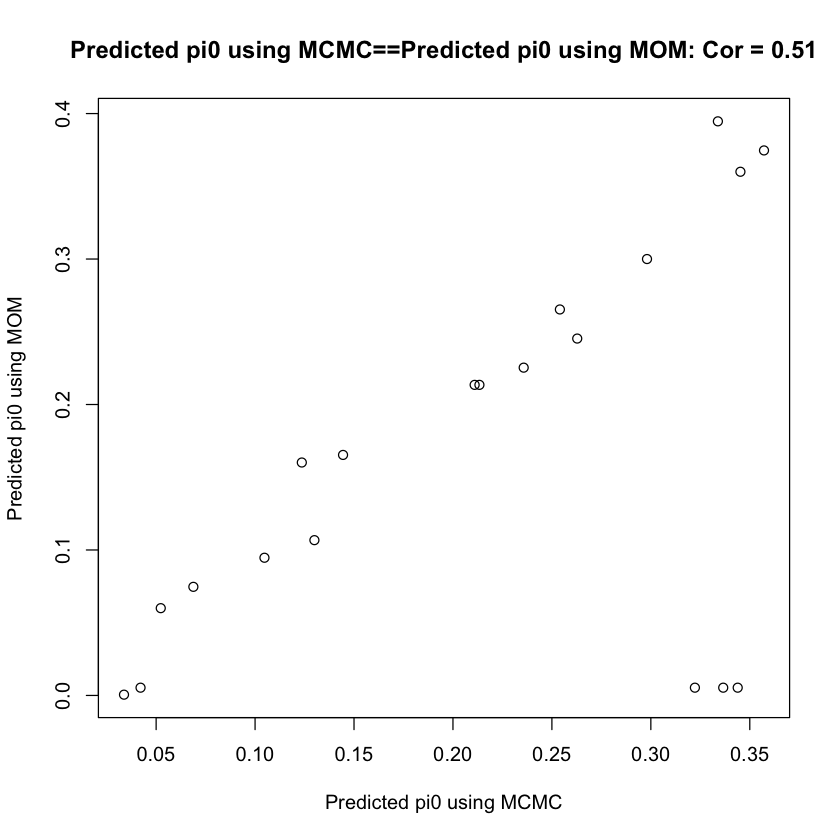

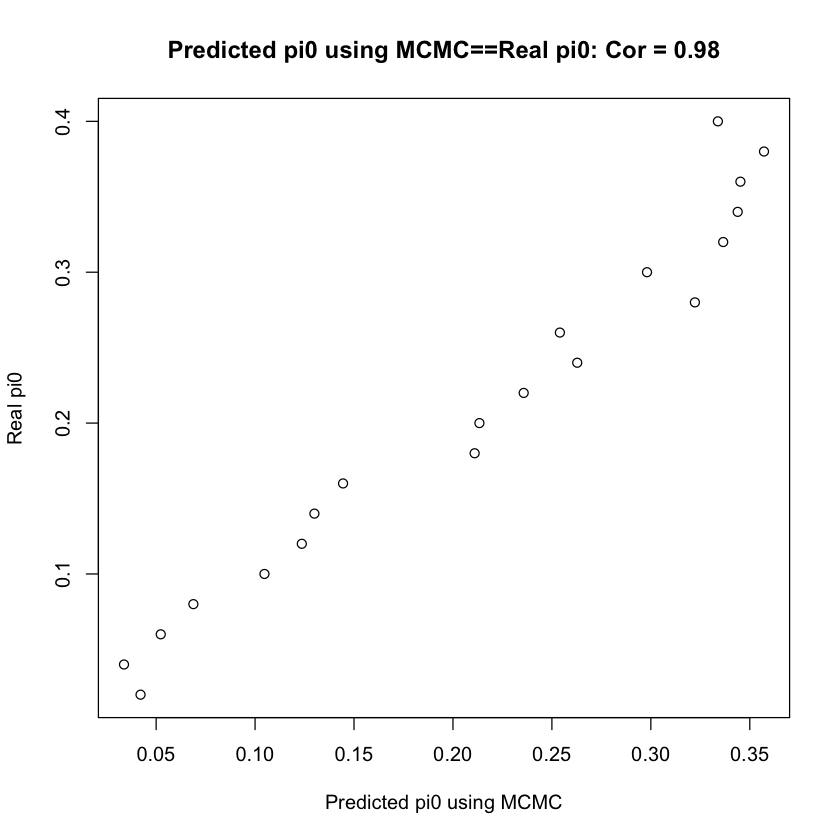

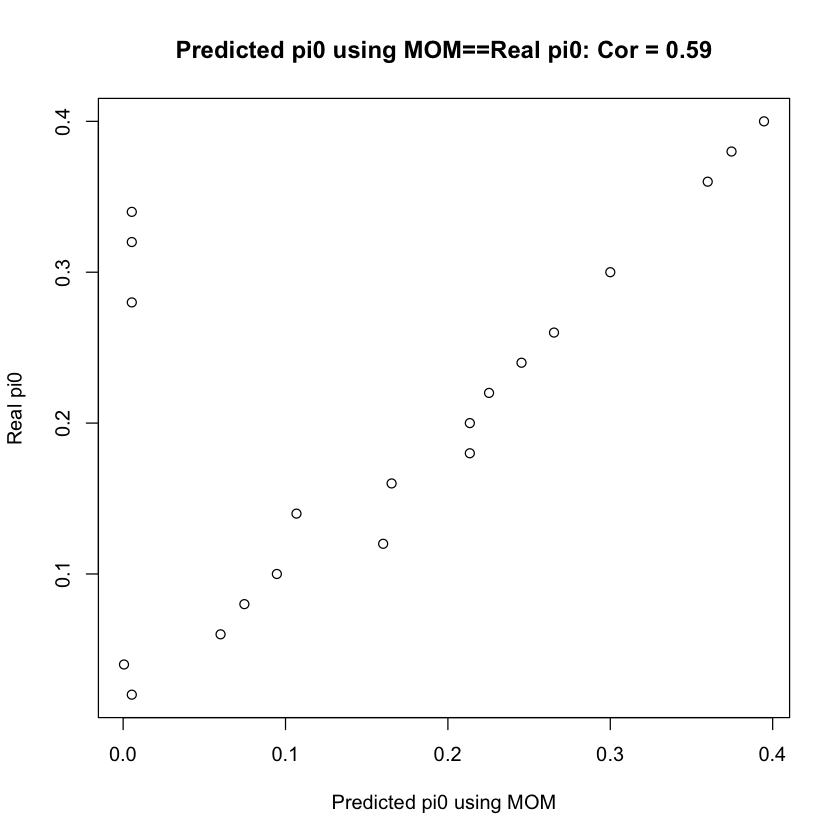

In [42]:
a3 <- cbind(outP, a1)
a3

colName <- c('Predicted pi0 using MCMC', 'Predicted pi0 using MOM', 'Real pi0')
for (i in 1:2){
    for (j in (i+1):3)
        plot(a3[, i], a3[, j], xlab = colName[i], ylab = colName[j],
            main = paste(colName[i], "==", colName[j], ": Cor = ", round(cor(a3[, i], a3[, j]), 2), sep = ""))
}


## For multiple categories

In [4]:
sDenovo2 <- simulator.denovo(N = N$dn, mu = data$mut.rate, mu.frac = mu.frac, pi = 0.06, 
                             gamma.mean = c(20, 4.7), beta = c(1, 1))

class(sDenovo2)
str(sDenovo2)

sCountDenovo2 <- (sDenovo2$sample)
str(sCountDenovo2)
muSimu <- sDenovo[[2]][, 1]

[1] "list"

List of 2
 $ sample     : num [1:18735, 1:2] 0 0 0 0 0 0 0 0 0 0 ...
 $ sample.info: num [1:18735, 1:6] 2.35e-05 2.17e-05 6.09e-06 5.64e-05 5.70e-05 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:6] "mu" "z" "" "" ...
 num [1:18735, 1:2] 0 0 0 0 0 0 0 0 0 0 ...


ERROR: Error in eval(expr, envir, enclos): object 'sDenovo' not found


In [5]:
denovoBinom2 <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ndn;

int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];
int<lower=0> yMis3dn[NN];
real<lower=0> mutMis3[NN];
}
parameters {
real<lower=0.0,upper=0.4> pi0;
real<lower=1> hyperGammaMeanLoFdn;
//real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;

real<lower=1> hyperGammaMeanMis3dn;
//real<lower=0.5> hyperBetaMis3dn;
real<lower=0.5> gammaMis3dn;



}

model {

real ps[K];
//pi0 ~ normal(0.1, 0.03);
//denovo lof
hyperGammaMeanLoFdn ~ uniform(1, 70); //normal(15, 100);
//hyperBetaLoFdn ~ normal(1, 0.01);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn, 1);

hyperGammaMeanMis3dn ~ uniform(1, 70); //normal(15, 100);
//hyperBetaLoFdn ~ normal(1, 0.01);
gammaMis3dn ~ gamma(hyperGammaMeanMis3dn, 1);


for (ii in 1:NN){
ps[1] <- log1m(pi0) 
//+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]);
+ poisson_log(yLoFdn[ii], Ndn*2*mutLoF[ii]) + poisson_log(yMis3dn[ii], Ndn*2*mutMis3[ii]);

ps[2] <- log(pi0)
//+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]*gammaLoFdn);
+ poisson_log(yLoFdn[ii], Ndn*2*mutLoF[ii]*gammaLoFdn) + poisson_log(yMis3dn[ii], Ndn*2*mutMis3[ii]*gammaMis3dn);

increment_log_prob(log_sum_exp(ps));
}

}
"


In [18]:
mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  sCountDenovo2[, 1]

mutMis3 <- data$mut.rate*mu.frac[2]
yMis3 <- sCountDenovo2[, 2]
mixdataSingle2 <- list(K = 2, 
                      yLoFdn = yLoF, mutLoF = mutLoF,
                      yMis3dn = yMis3, mutMis3 = mutMis3,
                      Ndn = N$dn, NN = length(yLoF))                 


In [19]:
library("rstan")
nSeed <- 233
mLoF2 <- stan_model(model_code = denovoBinom2)

fLoF2 <- vb(mLoF2, seed = nSeed, data = mixdataSingle2)

fLoF2

clang: warning: optimization flag '-ffat-lto-objects' is not supported
clang: warning: argument unused during compilation: '-ffat-lto-objects'

This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.010817 seconds
1000 iterations under these settings should take 10.817 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -4e+03             1.000            1.000
   200    -4236.0             0.501            1.000
   300    -4235.6             0.334            0.002   MEDIAN ELBO CONVERGED

Drawing 100

We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: 0854f170d14d15dcb156f0a39a75feed.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                      mean   sd  2.5%   25%   50%   75% 97.5%
pi0                   0.04 0.01  0.03  0.04  0.04  0.05  0.05
hyperGammaMeanLoFdn  26.78 7.21 15.35 21.74 25.80 30.89 43.66
gammaLoFdn           23.64 1.74 20.47 22.44 23.61 24.75 27.20
hyperGammaMeanMis3dn  4.20 1.91  1.89  2.87  3.72  4.94  9.44
gammaMis3dn           3.25 0.62  2.30  2.80  3.17  3.59  4.73
lp__                  0.00 0.00  0.00  0.00  0.00  0.00  0.00

Approximate samples were drawn using VB(meanfield) at Tue Feb 23 16:36:55 2016.

In [22]:
nIteration = 10000
nThin = floor(nIteration/1000)

testFitSingle2 <- stan(model_code = denovoBinom2,
                      data = mixdataSingle2, iter = nIteration, chains = 1, thin = nThin, 
                      #control = list(adapt_delta = 0.9),
                      pars = c('pi0','hyperGammaMeanLoFdn', 'hyperGammaMeanMis3dn'))


SAMPLING FOR MODEL '0854f170d14d15dcb156f0a39a75feed' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1, Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1, Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1, Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1, Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1, Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1, Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1, Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1, Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1, Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1, Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1, Iteration: 10000 / 10000 [100%]  (Sampling)# 
#  Elapsed Time: 389.337 seconds (Warm-up)
#                459.99 seconds (Sampling)
#                849.326 seconds (Total)
# 


Inference for Stan model: 0854f170d14d15dcb156f0a39a75feed.
1 chains, each with iter=10000; warmup=5000; thin=10; 
post-warmup draws per chain=500, total post-warmup draws=500.

                         mean se_mean   sd     2.5%      25%      50%      75%
pi0                      0.04    0.00 0.01     0.03     0.04     0.04     0.05
hyperGammaMeanLoFdn     25.58    0.31 6.91    13.56    20.86    25.00    29.86
hyperGammaMeanMis3dn     4.31    0.08 1.79     1.40     2.96     3.99     5.51
lp__                 -4226.32    0.08 1.66 -4230.26 -4227.17 -4226.00 -4225.10
                        97.5% n_eff Rhat
pi0                      0.06   500    1
hyperGammaMeanLoFdn     40.38   500    1
hyperGammaMeanMis3dn     8.06   500    1
lp__                 -4224.10   440    1

Samples were drawn using NUTS(diag_e) at Tue Feb 23 16:51:42 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, 

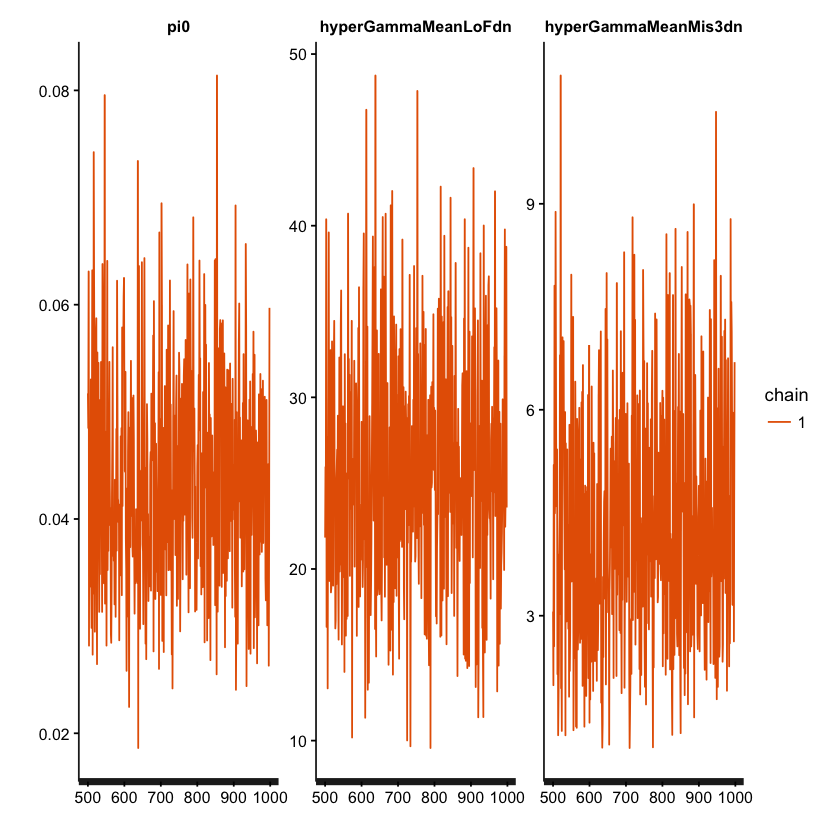

In [23]:
stan_trace(testFitSingle2)
testFitSingle2


In [30]:
source("newTADA2016/TADA/TADA.v1.1.R")
C=sum(yLoF)
listGamma <- NULL
listM <- NULL
d0 = 2

listK <- c(10, 50, 75, 100, 200, 500, 0.03*length(yLoF), 700, 1000, 1500, 2000, 2500, 3000)
for (k in 1:length(listK)){
  results=denovo.MOM(k= listK[k], N=N$dn, mu= mutLoF, C=C, beta=1, d= d0)
  gamma.mean.dn=results$gamma.mean
  M.expected=results$M
  listGamma[k] <- gamma.mean.dn
  listM[k] <- M.expected
}

M.observed <- length(yLoF[yLoF>= d0])
outResult <- cbind(round(listK, 0), round(listGamma, 2), round(listM, 2), 
                   round(listK/length(yLoF), 3), abs(listM - M.observed))
colnames(outResult) <- c("nGene", "GammaMean", "M.expected", "Risk_gene_proportion", "Distance_M.ob_AND_es")

outResult[order(outResult[, 5]), ]

nGene GammaMean M.expected Risk_gene_proportion Distance_M.ob_AND_es
 [1,]    50    363.36      21.56                0.003             3.442845
 [2,]    75    242.57      20.97                0.004             4.034708
 [3,]   100    182.18      19.29                0.005             5.709464
 [4,]   200     91.59      12.99                0.011            12.005605
 [5,]    10   1812.81       9.34                0.001            15.655258
 [6,]   500     37.24       5.51                0.027            19.489057
 [7,]   562     33.24       4.85                0.030            20.154883
 [8,]   700     26.88       3.77                0.037            21.226581
 [9,]  1000     19.12       2.48                0.053            22.522666
[10,]  1500     13.08       1.54                0.080            23.458335
[11,]  2000     10.06       1.12                0.107            23.881646
[12,]  2500      8.25       0.89                0.133            24.108079
[13,]  3000      7.04       0.74                0.160            24.259228

In [31]:
source("newTADA2016/TADA/TADA.v1.1.R")
C=sum(yLoF)
listGamma <- NULL
listM <- NULL
d0 = 1

listK <- c(10, 50, 75, 100, 200, 500, 0.03*length(yLoF), 700, 1000, 1500, 2000, 2500, 3000)
for (k in 1:length(listK)){
  results=denovo.MOM(k= listK[k], N=N$dn, mu= mutLoF, C=C, beta=1, d= d0)
  gamma.mean.dn=results$gamma.mean
  M.expected=results$M
  listGamma[k] <- gamma.mean.dn
  listM[k] <- M.expected
}

M.observed <- length(yLoF[yLoF>= d0])
outResult <- cbind(round(listK), round(listGamma, 2), round(listM, 2), 
                   round(listK/length(yLoF), 3), abs(listM - M.observed))
colnames(outResult) <- c("nGene", "GammaMean", "M.expected", "Risk_gene_proportion", "Distance_M.ob_AND_es")

outResult[order(outResult[, 5]), ]

nGene GammaMean M.expected Risk_gene_proportion Distance_M.ob_AND_es
 [1,]   100    182.18      37.32                0.005             230.6798
 [2,]    75    242.57      35.90                0.004             232.0969
 [3,]   200     91.59      35.27                0.011             232.7290
 [4,]    50    363.36      31.84                0.003             236.1557
 [5,]   500     37.24      25.36                0.027             242.6450
 [6,]   562     33.24      23.94                0.030             244.0600
 [7,]   700     26.88      21.40                0.037             246.6000
 [8,]  1000     19.12      17.63                0.053             250.3730
 [9,]  1500     13.08      14.06                0.080             253.9353
[10,]  2000     10.06      12.03                0.107             255.9703
[11,]    10   1812.81      10.85                0.001             257.1511
[12,]  2500      8.25      10.77                0.133             257.2311
[13,]  3000      7.04       9.88                0.160             258.1250

## Simulate for case-control AND de novo data

In [57]:
sDenovoCC <- simulator(N = N, mu = data$mut.rate, mu.frac = mu.frac[1], pi = 0.15, 
                             gamma.mean.dn = 20, beta.dn = 1,
                       gamma.mean.CC = 2.3, beta.CC = 4, 
                       rho1 = rho0[1], nu1 = nu0[1],
                       rho0 = rho0[1], nu0 = nu0[1])

class(sDenovoCC)
str(sDenovoCC)

sCountCC <- (sDenovoCC$sample)
str(sCountCC)

head(sCountCC)


[1] "list"

List of 2
 $ sample     : num [1:18735, 1:3] 0 0 0 1 0 0 0 0 0 0 ...
 $ sample.info: num [1:18735, 1:8] 2.35e-05 2.17e-05 6.09e-06 5.64e-05 5.70e-05 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:8] "mu" "z" "" "" ...
 num [1:18735, 1:3] 0 0 0 1 0 0 0 0 0 0 ...


[,1] [,2] [,3]
[1,]    0    0    0
[2,]    0    0    0
[3,]    0    0    0
[4,]    1    0    0
[5,]    0    2    0
[6,]    0    0    0

In [58]:
denovoCCBinom <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ndn;
int<lower=1> Ncase;
int<lower=1> Ncontrol;
int<lower=1> Ntotal;

int<lower=0> yCaseLoF[NN];
int<lower=0> yTotalLoF[NN];
int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];


real<lower=0.05> thetaH0;

}
parameters {
real<lower=0.001,upper=0.4> pi0;
real<lower=1> hyperGammaMeanLoFcc;
real<lower=0.5> hyperBetaLoFcc;
real<lower=0.5> gammaLoFcc;
real<lower=1> hyperGammaMeanLoFdn;
real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;


}

model {

real ps[K];
//pi0 ~ normal(0.1, 0.03);
//denovo lof
//pi0 ~ uniform(0, 0.2); //normal(0.04, 0.05);
hyperGammaMeanLoFdn ~ normal(15, 10);
hyperBetaLoFdn ~ normal(1, 0.01);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn*hyperBetaLoFdn, hyperBetaLoFdn);

hyperGammaMeanLoFcc ~ normal(15, 10);
hyperBetaLoFcc ~ normal(4, 0.01);
gammaLoFcc ~ gamma(hyperGammaMeanLoFcc*hyperBetaLoFcc, hyperBetaLoFcc);


for (ii in 1:NN){
ps[1] <- log1m(pi0) 
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], thetaH0);

ps[2] <- log(pi0)
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]*gammaLoFdn) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], gammaLoFcc*Ncase/(gammaLoFcc*Ncase + Ncontrol));

increment_log_prob(log_sum_exp(ps));
}

}
"


In [59]:
mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  sCountCC[, 1]
y.case.lof <- sCountCC[, 2]
y.control.lof <- sCountCC[, 3]

#y.case.lof <- y.case.lof + y.case.mis3; y.control.lof <- y.control.lof + y.control.mis3; mutLoF <- mutLoF + mutMis3
mixdataDenovoCC <- list(K = 2, 
                        yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                        yLoFdn = yLoF, mutLoF = mutLoF,
                        NN = length(y.case.lof),
                        Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                        Ndn = N$dn,
                        thetaH0 = N$ca/(N$ca + N$cn))


In [40]:
NSample <- 50000
mBothDenovoCC <- stan_model(model_code = denovoCCBinom)

nSeed1 <- floor(runif(1, 1, 10^6)) #233
fBothDenovoCC <- vb(mBothDenovoCC, seed = nSeed1,
                    data = mixdataDenovoCC,
                    iter = NSample, output_samples= 1000)



This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.0182 seconds
1000 iterations under these settings should take 18.2 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -1e+04             1.000            1.000
   200   -13451.8             0.504            1.000
   300   -13313.6             0.339            0.010
   400   -13327.6             0.255            0.010
   500   -13306.4             0.204            0.008   MEDIAN ELBO CONVERGED

Drawing 1000 samples from the approximate posterior.

In [41]:
fBothDenovoCC


We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: 164d5a370c0efe99cd0014a985c9baee.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                     mean   sd  2.5%   25%   50%   75% 97.5%
pi0                  0.13 0.01  0.12  0.13  0.13  0.14  0.14
hyperGammaMeanLoFcc  3.18 0.95  1.86  2.51  2.98  3.68  5.47
hyperBetaLoFcc       4.07 0.01  4.06  4.07  4.07  4.08  4.09
gammaLoFcc           2.72 0.08  2.57  2.66  2.71  2.77  2.87
hyperGammaMeanLoFdn 20.87 3.27 15.11 18.62 20.68 22.87 27.81
hyperBetaLoFdn       1.01 0.01  0.99  1.00  1.01  1.01  1.03
gammaLoFdn          22.19 1.10 20.17 21.43 22.17 22.90 24.30
lp__                 0.00 0.00  0.00  0.00  0.00  0.00  0.00

Approximate samples were drawn using VB(meanfield) at Tue Feb 23 17:26:12 2016.

In [38]:
nIteration = 3000
nThin = floor(nIteration/1000)
testFitDenovoCC <- stan(model_code = denovoCCBinom,
                        data = mixdataDenovoCC, iter = nIteration, 
                        chains = 2, cores = 2, thin = nThin,
#                        control = list(adapt_delta = 0.9),
                        pars = c('pi0',
                                 'hyperGammaMeanLoFdn', 'hyperGammaMeanLoFcc',
                                 'hyperBetaLoFdn', 'hyperBetaLoFcc'))


Inference for Stan model: 164d5a370c0efe99cd0014a985c9baee.
2 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=5000.

                         mean se_mean   sd      2.5%       25%       50%
pi0                      0.13    0.00 0.01      0.12      0.13      0.13
hyperGammaMeanLoFdn     22.32    0.08 4.25     14.49     19.41     22.06
hyperGammaMeanLoFcc      3.05    0.02 0.82      1.54      2.48      3.00
hyperBetaLoFdn           1.00    0.00 0.01      0.98      0.99      1.00
hyperBetaLoFcc           4.00    0.00 0.01      3.98      3.99      4.00
lp__                -13267.33    0.04 1.94 -13272.05 -13268.43 -13266.96
                          75%     97.5% n_eff Rhat
pi0                      0.14      0.15  2895    1
hyperGammaMeanLoFdn     25.16     30.93  3212    1
hyperGammaMeanLoFcc      3.57      4.79  2714    1
hyperBetaLoFdn           1.01      1.02  4039    1
hyperBetaLoFcc           4.01      4.02  4456    1
lp__ 

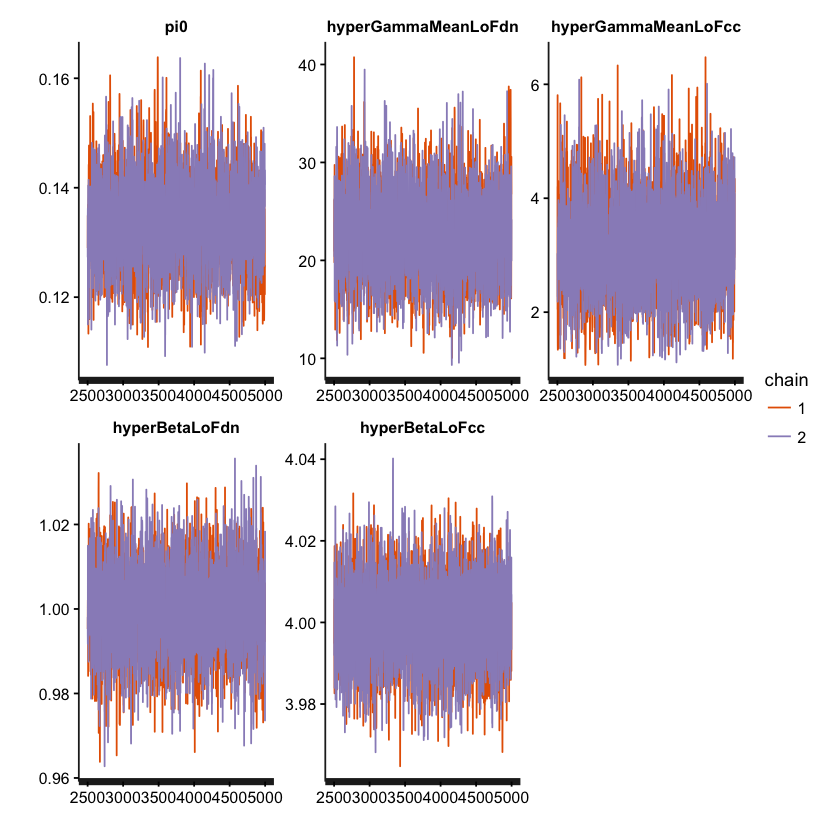

In [39]:
testFitDenovoCC
stan_trace(testFitDenovoCC)

## We will simulate case-control and de novo variants having different $\pi$

In [63]:
## Case-control with pi = 0.15
sDenovoCC <- simulator(N = N, mu = data$mut.rate, mu.frac = mu.frac[1], pi = 0.15, 
                             gamma.mean.dn = 20, beta.dn = 1,
                       gamma.mean.CC = 2.3, beta.CC = 4, 
                       rho1 = rho0[1], nu1 = nu0[1],
                       rho0 = rho0[1], nu0 = nu0[1])

class(sDenovoCC)
str(sDenovoCC)

sCountCC <- (sDenovoCC$sample)

## De novo with pi = 0.06

sDenovoCC2 <- simulator(N = N, mu = data$mut.rate, mu.frac = mu.frac[1], pi = 0.06, 
                             gamma.mean.dn = 20, beta.dn = 1,
                       gamma.mean.CC = 2.3, beta.CC = 4, 
                       rho1 = rho0[1], nu1 = nu0[1],
                       rho0 = rho0[1], nu0 = nu0[1])


sCountCC2 <- (sDenovoCC2$sample)

counts <- cbind(sCountCC2[, 1], sCountCC[, 2:3])

table(counts[, 1])
y1 <- (counts[, 1])
length(y1[y1 > 0])/length(y1)

sS <- cbind(sDenovoCC[[2]][, 2], sDenovoCC2[[2]][, 2]) #Sample status
head(sS)
dim(sS[(sS[, 1] == 1) | (sS[, 2] == 1), ])/dim(sS)[1]


[1] "list"

List of 2
 $ sample     : num [1:18735, 1:3] 0 0 0 0 0 0 0 0 1 0 ...
 $ sample.info: num [1:18735, 1:8] 2.35e-05 2.17e-05 6.09e-06 5.64e-05 5.70e-05 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:8] "mu" "z" "" "" ...



    0     1     2     3     4 
18462   261    10     1     1 

[1] 0.01457166

[,1] [,2]
[1,]    1    0
[2,]    1    0
[3,]    0    0
[4,]    0    0
[5,]    0    0
[6,]    0    0

[1] 0.2033626902 0.0001067521

In [64]:
mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  counts[, 1]
y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]

#y.case.lof <- y.case.lof + y.case.mis3; y.control.lof <- y.control.lof + y.control.mis3; mutLoF <- mutLoF + mutMis3
mixdataDenovoCC <- list(K = 2, 
                        yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                        yLoFdn = yLoF, mutLoF = mutLoF,
                        NN = length(y.case.lof),
                        Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                        Ndn = N$dn,
                        thetaH0 = N$ca/(N$ca + N$cn))


In [65]:
library("rstan")
NSample <- 50000
mBothDenovoCC <- stan_model(model_code = denovoCCBinom)

nSeed1 <- floor(runif(1, 1, 10^6)) #233
fBothDenovoCC <- vb(mBothDenovoCC, seed = nSeed1,
                    data = mixdataDenovoCC)


Loading required package: ggplot2
rstan (Version 2.9.0, packaged: 2016-01-05 16:17:47 UTC, GitRev: 05c3d0058b6a)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


clang: warning: optimization flag '-ffat-lto-objects' is not supported
clang: warning: argument unused during compilation: '-ffat-lto-objects'

This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.017157 seconds
1000 iterations under these settings should take 17.157 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -1e+04             1.000            1.000
   200   -11760.8             0.504            1.000
   300   -11736.2             0.337            0.008   MEDIAN ELBO CONVERGED

Drawing 100

In [66]:
fBothDenovoCC

We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: 164d5a370c0efe99cd0014a985c9baee.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                    mean   sd 2.5%  25%  50%  75% 97.5%
pi0                 0.15 0.01 0.13 0.15 0.15 0.16  0.17
hyperGammaMeanLoFcc 2.94 1.02 1.68 2.23 2.66 3.39  5.64
hyperBetaLoFcc      4.10 0.02 4.06 4.09 4.10 4.11  4.14
gammaLoFcc          2.77 0.06 2.66 2.73 2.77 2.81  2.88
hyperGammaMeanLoFdn 8.30 2.62 4.43 6.38 7.91 9.64 14.73
hyperBetaLoFdn      0.99 0.01 0.98 0.99 0.99 1.00  1.01
gammaLoFdn          7.68 0.77 6.26 7.13 7.67 8.18  9.28
lp__                0.00 0.00 0.00 0.00 0.00 0.00  0.00

Approximate samples were drawn using VB(meanfield) at Wed Mar  9 14:16:21 2016.

In [67]:
nIteration = 3000
nThin = floor(nIteration/1000)
testFitDenovoCC <- stan(model_code = denovoCCBinom,
                        data = mixdataDenovoCC, iter = nIteration, 
                        chains = 2, cores = 2, thin = nThin,
#                        control = list(adapt_delta = 0.9),
                        pars = c('pi0',
                                 'hyperGammaMeanLoFdn', 'hyperGammaMeanLoFcc',
                                 'hyperBetaLoFdn', 'hyperBetaLoFcc'))


In [68]:
testFitDenovoCC

Inference for Stan model: 164d5a370c0efe99cd0014a985c9baee.
2 chains, each with iter=3000; warmup=1500; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                         mean se_mean   sd      2.5%       25%       50%
pi0                      0.14    0.00 0.01      0.12      0.14      0.14
hyperGammaMeanLoFdn      8.52    0.09 2.78      3.67      6.54      8.36
hyperGammaMeanLoFcc      2.97    0.03 0.86      1.46      2.36      2.90
hyperBetaLoFdn           1.00    0.00 0.01      0.98      0.99      1.00
hyperBetaLoFcc           4.00    0.00 0.01      3.98      3.99      4.00
lp__                -11670.43    0.07 1.94 -11675.27 -11671.44 -11669.98
                          75%     97.5% n_eff Rhat
pi0                      0.15      0.16   827 1.00
hyperGammaMeanLoFdn     10.39     14.62   934 1.00
hyperGammaMeanLoFcc      3.58      4.69   775 1.00
hyperBetaLoFdn           1.01      1.02   666 1.01
hyperBetaLoFcc           4.01      4.02  1000 1.00
lp__  

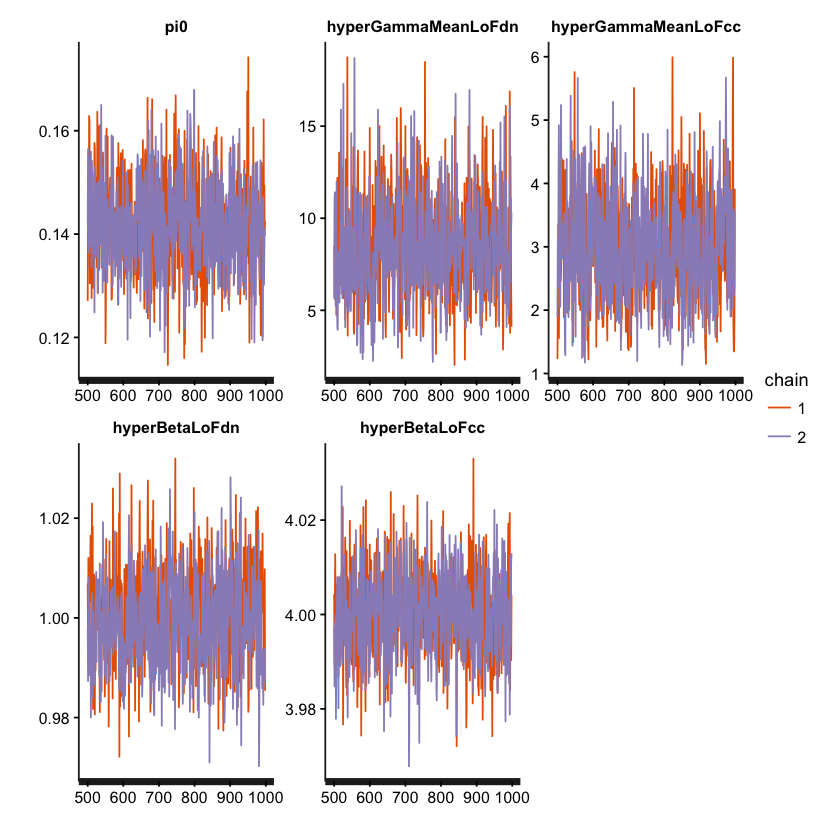

In [69]:
stan_trace(testFitDenovoCC)

In [36]:
nIteration = 3000
nThin = floor(nIteration/1000)

mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  counts[, 1]

mixdataSingle <- list(K = 2, 
                      yLoFdn = yLoF, mutLoF = mutLoF,
                      Ndn = N$dn, NN = length(yLoF))                 

testFitSingle <- stan(model_code = denovoBinomSingle,
                      data = mixdataSingle, iter = nIteration, chains = 1, thin = nThin, 
                      #control = list(adapt_delta = 0.9),
                      pars = c('pi0','hyperGammaMeanLoFdn'))


SAMPLING FOR MODEL 'e7bbaacf0e818149de4ff9f10e60cad7' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 3000 [  0%]  (Warmup)
Chain 1, Iteration:  300 / 3000 [ 10%]  (Warmup)
Chain 1, Iteration:  600 / 3000 [ 20%]  (Warmup)
Chain 1, Iteration:  900 / 3000 [ 30%]  (Warmup)
Chain 1, Iteration: 1200 / 3000 [ 40%]  (Warmup)
Chain 1, Iteration: 1500 / 3000 [ 50%]  (Warmup)
Chain 1, Iteration: 1501 / 3000 [ 50%]  (Sampling)
Chain 1, Iteration: 1800 / 3000 [ 60%]  (Sampling)
Chain 1, Iteration: 2100 / 3000 [ 70%]  (Sampling)
Chain 1, Iteration: 2400 / 3000 [ 80%]  (Sampling)
Chain 1, Iteration: 2700 / 3000 [ 90%]  (Sampling)
Chain 1, Iteration: 3000 / 3000 [100%]  (Sampling)# 
#  Elapsed Time: 128.292 seconds (Warm-up)
#                141.049 seconds (Sampling)
#                269.341 seconds (Total)
# 


In [37]:
testFitSingle

Inference for Stan model: e7bbaacf0e818149de4ff9f10e60cad7.
1 chains, each with iter=3000; warmup=1500; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=500.

                        mean se_mean   sd     2.5%      25%      50%      75%
pi0                     0.07    0.00 0.02     0.04     0.06     0.07     0.08
hyperGammaMeanLoFdn    19.82    0.35 6.08     9.35    15.73    19.19    23.58
lp__                -1579.30    0.07 1.28 -1582.54 -1579.86 -1578.99 -1578.34
                       97.5% n_eff Rhat
pi0                     0.12   327    1
hyperGammaMeanLoFdn    33.71   302    1
lp__                -1577.81   367    1

Samples were drawn using NUTS(diag_e) at Tue Feb 23 22:33:14 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

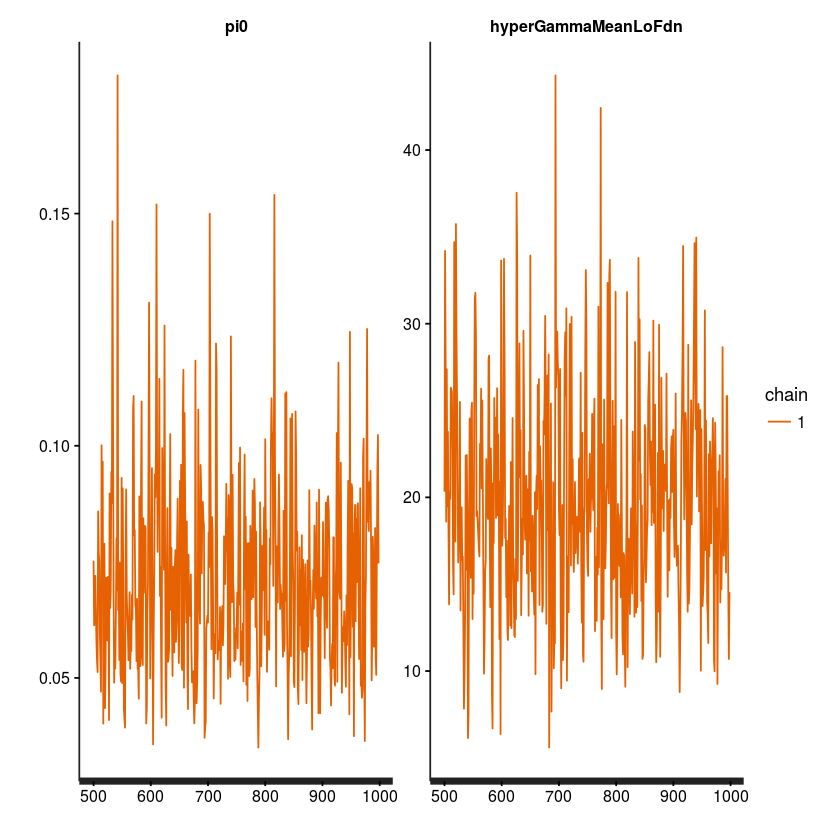

In [38]:
stan_trace(testFitSingle)

### Test for only simulated case-control data

In [12]:
onlyCCBinom <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ncase;
int<lower=1> Ncontrol;
int<lower=1> Ntotal;
int<lower=0> yCaseLoF[NN];
int<lower=0> yTotalLoF[NN];
real<lower=0.05> thetaH0;

}
parameters {
real<lower=0.001,upper=0.99> pi0;
real<lower=1> hyperGammaMeanLoFcc;
real<lower=0.5> hyperBetaLoFcc;
real<lower=0.5> gammaLoFcc;


}

model {

real ps[K];

hyperGammaMeanLoFcc ~ normal(15, 10);
hyperBetaLoFcc ~ normal(4, 0.01);
gammaLoFcc ~ gamma(hyperGammaMeanLoFcc*hyperBetaLoFcc, hyperBetaLoFcc);


for (ii in 1:NN){
ps[1] <- log1m(pi0) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], thetaH0);

ps[2] <- log(pi0)
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], gammaLoFcc*Ncase/(gammaLoFcc*Ncase + Ncontrol));

increment_log_prob(log_sum_exp(ps));
}

}
"

In [45]:
#y.case.lof <- y.case.lof + y.case.mis3; y.control.lof <- y.control.lof + y.control.mis3; mutLoF <- mutLoF + mutMis3
y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]

onlyCCData <- list(K = 2, 
                        yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                        NN = length(y.case.lof),
                        Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                        Ndn = N$dn,
                        thetaH0 = N$ca/(N$ca + N$cn))
library("rstan")

nSeed1 <- 12345 #233
mCC <- stan_model(model_code = onlyCCBinom)
fCC <- vb(mCC, seed = nSeed1, data = onlyCCData)
fCC


This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.015099 seconds
1000 iterations under these settings should take 15.099 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Iteration: 250 / 250 [100%]  (Adaptation)
Success! Found best value [eta = 0.1].

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -6e+04             1.000            1.000
   200   -59293.6             0.521            1.000
   300  -104021.6             0.491            0.430
   400   -58118.9             0.566            0.790
   500   -55601.0             0.462            0.430
   600   -55722.4             0.385            0.43

We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: bc40862a0bd2774c7ac2181e2b90a2ae.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                    mean   sd 2.5%  25%  50%  75% 97.5%
pi0                 0.56 0.18 0.21 0.44 0.58 0.70  0.86
hyperGammaMeanLoFcc 2.95 2.46 1.17 1.63 2.17 3.39  9.19
hyperBetaLoFcc      1.77 2.18 0.55 0.79 1.12 1.98  6.79
gammaLoFcc          2.02 0.74 1.08 1.49 1.86 2.39  3.90
lp__                0.00 0.00 0.00 0.00 0.00 0.00  0.00

Approximate samples were drawn using VB(meanfield) at Tue Feb 23 22:54:26 2016.

In [46]:
nIteration = 3000
nThin = floor(nIteration/1000)
nChain = nThin
nCore = nChain
testFitSingleCC <- stan(model_code = onlyCCBinom,
                      data = onlyCCData, iter = nIteration, chains = nChain,
                        thin = nThin,
                        cores = nCore,
#                      control = list(adapt_delta = 0.9),
                      pars = c('pi0','hyperGammaMeanLoFcc', 'hyperBetaLoFcc'))


Inference for Stan model: bc40862a0bd2774c7ac2181e2b90a2ae.
3 chains, each with iter=3000; warmup=1500; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=1500.

                         mean se_mean   sd      2.5%       25%       50%
pi0                      0.14    0.00 0.01      0.12      0.13      0.14
hyperGammaMeanLoFcc      3.07    0.02 0.85      1.52      2.47      3.00
hyperBetaLoFcc           4.00    0.00 0.01      3.98      3.99      4.00
lp__                -10357.06    0.05 1.59 -10361.11 -10357.85 -10356.66
                          75%     97.5% n_eff Rhat
pi0                      0.14      0.16  1233    1
hyperGammaMeanLoFcc      3.63      4.84  1325    1
hyperBetaLoFcc           4.01      4.02  1500    1
lp__                -10355.89 -10355.16   995    1

Samples were drawn using NUTS(diag_e) at Tue Feb 23 23:03:52 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains

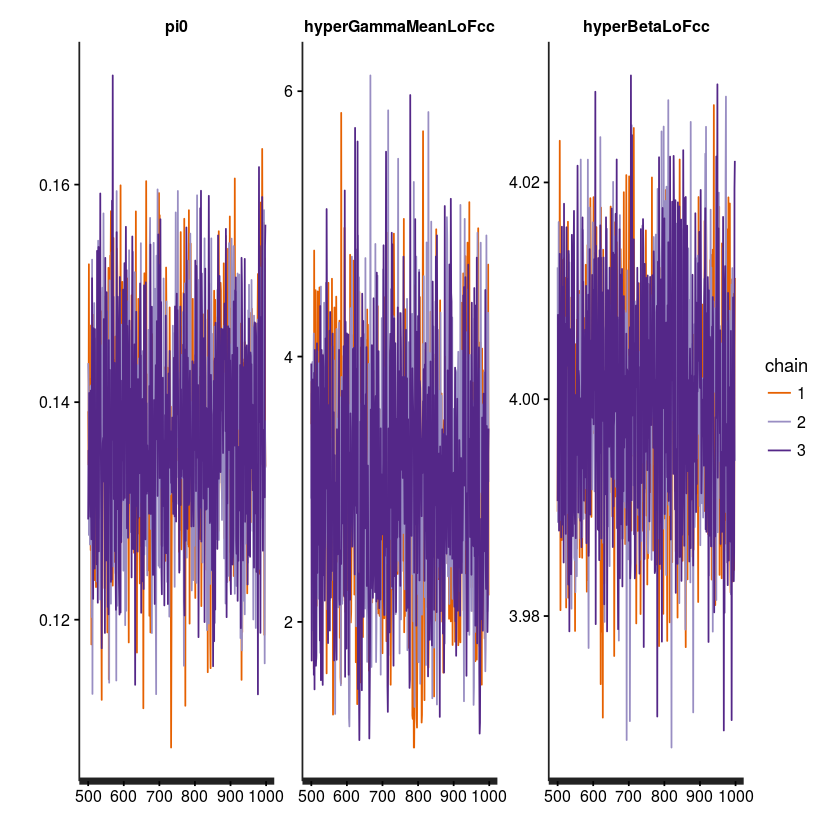

In [47]:
stan_trace(testFitSingleCC)
testFitSingleCC

### Change $\pi$: de novo $\pi$ >  case-control $\pi$

In [4]:
## Case-control with pi = 0.15
sDenovoCC <- simulator(N = N, mu = data$mut.rate, mu.frac = mu.frac[1], pi = 0.05, 
                             gamma.mean.dn = 20, beta.dn = 1,
                       gamma.mean.CC = 2.3, beta.CC = 4, 
                       rho1 = rho0[1], nu1 = nu0[1],
                       rho0 = rho0[1], nu0 = nu0[1])

class(sDenovoCC)
str(sDenovoCC)

sCountCC <- (sDenovoCC$sample)

## De novo with pi = 0.06

sDenovoCC2 <- simulator(N = N, mu = data$mut.rate, mu.frac = mu.frac[1], pi = 0.2, 
                             gamma.mean.dn = 20, beta.dn = 1,
                       gamma.mean.CC = 2.3, beta.CC = 4, 
                       rho1 = rho0[1], nu1 = nu0[1],
                       rho0 = rho0[1], nu0 = nu0[1])


sCountCC2 <- (sDenovoCC2$sample)

counts <- cbind(sCountCC2[, 1], sCountCC[, 2:3])

table(counts[, 1])
y1 <- (counts[, 1])
length(y1[y1 > 0])/length(y1)

[1] "list"

List of 2
 $ sample     : num [1:18735, 1:3] 0 0 0 0 0 0 0 0 0 0 ...
 $ sample.info: num [1:18735, 1:8] 2.35e-05 2.17e-05 6.09e-06 5.64e-05 5.70e-05 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:8] "mu" "z" "" "" ...



    0     1     2     3     4     5 
18109   575    39    10     1     1 

[1] 0.0334134

In [6]:
library("rstan")
mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  counts[, 1]
y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]

#y.case.lof <- y.case.lof + y.case.mis3; y.control.lof <- y.control.lof + y.control.mis3; mutLoF <- mutLoF + mutMis3
mixdataDenovoCC <- list(K = 2, 
                        yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                        yLoFdn = yLoF, mutLoF = mutLoF,
                        NN = length(y.case.lof),
                        Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                        Ndn = N$dn,
                        thetaH0 = N$ca/(N$ca + N$cn))


Loading required package: ggplot2
rstan (Version 2.9.0, packaged: 2016-01-05 16:17:47 UTC, GitRev: 05c3d0058b6a)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


In [7]:
NSample <- 50000
mBothDenovoCC <- stan_model(model_code = denovoCCBinom)

nSeed1 <- floor(runif(1, 1, 10^6)) #233
fBothDenovoCC <- vb(mBothDenovoCC, seed = nSeed1,
                    data = mixdataDenovoCC)


clang: warning: optimization flag '-ffat-lto-objects' is not supported
clang: warning: argument unused during compilation: '-ffat-lto-objects'

This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.017094 seconds
1000 iterations under these settings should take 17.094 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -1e+04             1.000            1.000
   200   -13008.5             0.502            1.000
   300   -12972.9             0.336            0.004   MEDIAN ELBO CONVERGED

Drawing 100

In [8]:
fBothDenovoCC

We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: 164d5a370c0efe99cd0014a985c9baee.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                     mean   sd  2.5%   25%   50%   75% 97.5%
pi0                  0.11 0.01  0.10  0.11  0.11  0.12  0.13
hyperGammaMeanLoFcc  2.34 0.77  1.43  1.80  2.16  2.69  4.26
hyperBetaLoFcc       3.98 0.02  3.95  3.97  3.98  3.99  4.02
gammaLoFcc           1.80 0.06  1.70  1.77  1.80  1.84  1.92
hyperGammaMeanLoFdn 24.92 4.86 17.15 21.34 24.39 27.92 36.12
hyperBetaLoFdn       1.00 0.01  0.98  0.99  1.00  1.01  1.02
gammaLoFdn          28.11 1.34 25.45 27.15 28.16 29.02 30.70
lp__                 0.00 0.00  0.00  0.00  0.00  0.00  0.00

Approximate samples were drawn using VB(meanfield) at Wed Feb 24 15:14:29 2016.

In [10]:
nIteration = 3000
nThin = floor(nIteration/1000)
testFitDenovoCC <- stan(model_code = denovoCCBinom,
                        data = mixdataDenovoCC, iter = nIteration, 
                        chains = 2, cores = 2, thin = nThin,
#                        control = list(adapt_delta = 0.9),
                        pars = c('pi0',
                                 'hyperGammaMeanLoFdn', 'hyperGammaMeanLoFcc',
                                 'hyperBetaLoFdn', 'hyperBetaLoFcc'))


In [11]:
testFitDenovoCC

Inference for Stan model: 164d5a370c0efe99cd0014a985c9baee.
2 chains, each with iter=3000; warmup=1500; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                         mean se_mean   sd      2.5%       25%       50%
pi0                      0.12    0.00 0.01      0.10      0.11      0.12
hyperGammaMeanLoFdn     25.83    0.17 4.82     17.08     22.46     25.62
hyperGammaMeanLoFcc      2.30    0.02 0.68      1.14      1.80      2.25
hyperBetaLoFdn           1.00    0.00 0.01      0.98      0.99      1.00
hyperBetaLoFcc           4.00    0.00 0.01      3.98      3.99      4.00
lp__                -12958.25    0.07 1.86 -12962.68 -12959.21 -12957.93
                          75%     97.5% n_eff Rhat
pi0                      0.12      0.13   914    1
hyperGammaMeanLoFdn     29.36     35.05   787    1
hyperGammaMeanLoFcc      2.74      3.84   805    1
hyperBetaLoFdn           1.01      1.02   875    1
hyperBetaLoFcc           4.01      4.02   952    1
lp__  

In [13]:
testFitDenovoCC

Inference for Stan model: 164d5a370c0efe99cd0014a985c9baee.
2 chains, each with iter=3000; warmup=1500; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                         mean se_mean   sd      2.5%       25%       50%
pi0                      0.12    0.00 0.01      0.10      0.11      0.12
hyperGammaMeanLoFdn     25.83    0.17 4.82     17.08     22.46     25.62
hyperGammaMeanLoFcc      2.30    0.02 0.68      1.14      1.80      2.25
hyperBetaLoFdn           1.00    0.00 0.01      0.98      0.99      1.00
hyperBetaLoFcc           4.00    0.00 0.01      3.98      3.99      4.00
lp__                -12958.25    0.07 1.86 -12962.68 -12959.21 -12957.93
                          75%     97.5% n_eff Rhat
pi0                      0.12      0.13   914    1
hyperGammaMeanLoFdn     29.36     35.05   787    1
hyperGammaMeanLoFcc      2.74      3.84   805    1
hyperBetaLoFdn           1.01      1.02   875    1
hyperBetaLoFcc           4.01      4.02   952    1
lp__  

In [14]:
#y.case.lof <- y.case.lof + y.case.mis3; y.control.lof <- y.control.lof + y.control.mis3; mutLoF <- mutLoF + mutMis3
y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]

onlyCCData <- list(K = 2, 
                        yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                        NN = length(y.case.lof),
                        Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                        Ndn = N$dn,
                        thetaH0 = N$ca/(N$ca + N$cn))
library("rstan")

nSeed1 <- 12345 #233
mCC <- stan_model(model_code = onlyCCBinom)
fCC <- vb(mCC, seed = nSeed1, data = onlyCCData)
fCC

clang: warning: optimization flag '-ffat-lto-objects' is not supported
clang: warning: argument unused during compilation: '-ffat-lto-objects'

This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.013886 seconds
1000 iterations under these settings should take 13.886 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Iteration: 250 / 250 [100%]  (Adaptation)
Success! Found best value [eta = 0.1].

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -6e+04             1.000            1.000
   200   -58601.9             0.521            1.000
   300  -103361.3             0.492            0.433
   400   -5737

We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: bc40862a0bd2774c7ac2181e2b90a2ae.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                    mean   sd 2.5%  25%  50%  75% 97.5%
pi0                 0.57 0.19 0.19 0.43 0.58 0.71  0.87
hyperGammaMeanLoFcc 2.93 2.44 1.17 1.62 2.15 3.36  9.10
hyperBetaLoFcc      1.77 2.18 0.55 0.79 1.12 1.98  6.79
gammaLoFcc          1.89 1.03 0.83 1.21 1.61 2.29  4.61
lp__                0.00 0.00 0.00 0.00 0.00 0.00  0.00

Approximate samples were drawn using VB(meanfield) at Wed Feb 24 16:48:19 2016.

In [15]:
nIteration = 3000
nThin = floor(nIteration/1000)
nChain = nThin
nCore = 3
testFitSingleCC <- stan(model_code = onlyCCBinom,
                      data = onlyCCData, iter = nIteration, chains = nChain,
                        thin = nThin,
                        cores = nCore,
#                      control = list(adapt_delta = 0.9),
                      pars = c('pi0','hyperGammaMeanLoFcc', 'hyperBetaLoFcc'))


In [16]:
testFitSingleCC

Inference for Stan model: bc40862a0bd2774c7ac2181e2b90a2ae.
3 chains, each with iter=3000; warmup=1500; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=1500.

                        mean se_mean   sd     2.5%      25%      50%      75%
pi0                     0.04    0.00 0.01     0.03     0.04     0.04     0.05
hyperGammaMeanLoFcc     2.93    0.02 0.81     1.51     2.38     2.88     3.42
hyperBetaLoFcc          4.00    0.00 0.01     3.98     3.99     4.00     4.01
lp__                -9404.31    0.05 1.47 -9408.03 -9405.06 -9403.97 -9403.22
                       97.5% n_eff Rhat
pi0                     0.06  1315    1
hyperGammaMeanLoFcc     4.69  1424    1
hyperBetaLoFcc          4.02  1478    1
lp__                -9402.52   918    1

Samples were drawn using NUTS(diag_e) at Wed Feb 24 16:55:37 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [17]:
nIteration = 3000
nThin = floor(nIteration/1000)

mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  counts[, 1]

mixdataSingle <- list(K = 2, 
                      yLoFdn = yLoF, mutLoF = mutLoF,
                      Ndn = N$dn, NN = length(yLoF))                 

testFitSingle <- stan(model_code = denovoBinomSingle,
                      data = mixdataSingle, iter = nIteration, chains = 1, thin = nThin, 
                      #control = list(adapt_delta = 0.9),
                      pars = c('pi0','hyperGammaMeanLoFdn'))

clang: warning: optimization flag '-ffat-lto-objects' is not supported
clang: warning: argument unused during compilation: '-ffat-lto-objects'

SAMPLING FOR MODEL 'e7bbaacf0e818149de4ff9f10e60cad7' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 3000 [  0%]  (Warmup)
Chain 1, Iteration:  300 / 3000 [ 10%]  (Warmup)
Chain 1, Iteration:  600 / 3000 [ 20%]  (Warmup)
Chain 1, Iteration:  900 / 3000 [ 30%]  (Warmup)
Chain 1, Iteration: 1200 / 3000 [ 40%]  (Warmup)
Chain 1, Iteration: 1500 / 3000 [ 50%]  (Warmup)
Chain 1, Iteration: 1501 / 3000 [ 50%]  (Sampling)
Chain 1, Iteration: 1800 / 3000 [ 60%]  (Sampling)
Chain 1, Iteration: 2100 / 3000 [ 70%]  (Sampling)
Chain 1, Iteration: 2400 / 3000 [ 80%]  (Sampling)
Chain 1, Iteration: 2700 / 3000 [ 90%]  (Sampling)
Chain 1, Iteration: 3000 / 3000 [100%]  (Sampling)# 
#  Elapsed Time: 79.3808 seconds (Warm-up)
#                82.8886 seconds (Sampling)
#                162.269 seconds (Total)
# 


In [18]:
testFitSingle

Inference for Stan model: e7bbaacf0e818149de4ff9f10e60cad7.
1 chains, each with iter=3000; warmup=1500; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=500.

                        mean se_mean   sd     2.5%      25%      50%      75%
pi0                     0.21    0.00 0.03     0.17     0.20     0.21     0.23
hyperGammaMeanLoFdn    19.26    0.27 5.10    10.27    15.59    18.94    22.15
lp__                -2777.74    0.07 1.24 -2780.96 -2778.33 -2777.48 -2776.80
                       97.5% n_eff Rhat
pi0                     0.27   375    1
hyperGammaMeanLoFdn    30.17   362    1
lp__                -2776.27   323    1

Samples were drawn using NUTS(diag_e) at Wed Feb 24 17:08:09 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).